In [1]:
# Basic Libraries
import sys
import time
import gc
import random
import copy 
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Data Handling and Image Processing
from torchvision import datasets, transforms

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from skimage.metrics import structural_similarity as ssim

# Style for Matplotlib
import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Scientific Computing and Machine Learning
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import subspace_angles
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# Custom Modules and Extensions
sys.path.append("../netrep/")
sys.path.append("../svcca/")

import networks as nets  # Contains RNNs
import net_helpers
import mpn_tasks
import helper
import mpn

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Memory Optimization
gc.collect()
torch.cuda.empty_cache()

In [2]:
!hostname

n04


In [3]:
# 0 Red, 1 blue, 2 green, 3 purple, 4 orange, 5 teal, 6 gray, 7 pink, 8 yellow
c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',] * 10
c_vals_l = ['#feb2b2', '#90cdf4', '#9ae6b4', '#d6bcfa', '#fbd38d', '#81e6d9', '#e2e8f0', '#fbb6ce', '#faf089',] * 10
c_vals_d = ['#9b2c2c', '#2c5282', '#276749', '#553c9a', '#9c4221', '#285e61', '#2d3748', '#97266d', '#975a16',] * 10 
l_vals = ['solid', 'dashed', 'dotted', 'dashdot', '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
markers_vals = ['o', 'v', '*', 'x', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
linestyles = ["-", "--", "-."]

In [4]:
# Reload modules if changes have been made to them
from importlib import reload

reload(nets)
reload(net_helpers)

fixseed = False # randomize setting the seed may lead to not perfectly solved results
seed = random.randint(1,1000) if not fixseed else 8 # random set the seed to test robustness by default
print(f"Set seed {seed}")
np.random.seed(seed)
torch.manual_seed(seed)

hyp_dict = {}

hyp_dict['task_type'] = 'multitask' # int, NeuroGym, multitask
hyp_dict['mode_for_all'] = "random_batch"
hyp_dict['ruleset'] = 'delaygofamily' # low_dim, all, test

accept_rules = ('fdgo', 'fdanti', 'delaygo', 'delayanti', 'reactgo', 'reactanti', 
                'delaydm1', 'delaydm2', 'dmsgo', 'dmcgo', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm')


rules_dict = \
    {'all' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     'low_dim' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
                 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
                 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     'gofamily': ['fdgo', 'fdanti', 'reactgo', 'reactanti', 'delaygo', 'delayanti'],
     'delaygo': ['delaygo'],
     'delaygofamily': ['delaygo', 'delayanti'],
     'fdgo': ['fdgo'],
     'fdfamily': ['fdgo', 'fdanti'],
     'reactgo': ['reactgo'],
     'reactfamily': ['reactgo', 'reactanti'],
     'delaydm1': ['delaydm1'],
     'delaydmfamily': ['delaydm1', 'delaydm2'],
     'dmsgofamily': ['dmsgo', 'dmsnogo'],
     'dmsgo': ['dmsgo'],
     'dmcgo': ['dmcgo'],
     'contextdelayfamily': ['contextdelaydm1', 'contextdelaydm2'],
    }
    

# This can either be used to set parameters OR set parameters and train
train = True # whether or not to train the network
verbose = True
hyp_dict['run_mode'] = 'minimal' # minimal, debug
hyp_dict['chosen_network'] = "dmpn"

# suffix for saving images
# inputadd, Wfix, WL2, hL2
# inputrandom, Wtrain
# noise001
# largeregularization
# trainetalambda

mpn_depth = 1
n_hidden = 200

hyp_dict['addon_name'] = "Wtrain+WL2+hL2"
hyp_dict['addon_name'] += f"+hidden{n_hidden}"

# for coding 
if hyp_dict['chosen_network'] in ("gru", "vanilla"):
    mpn_depth = 1

def current_basic_params():
    task_params = {
        'task_type': hyp_dict['task_type'],
        'rules': rules_dict[hyp_dict['ruleset']],
        'dt': 40, # ms, directly influence sequence lengths,
        'ruleset': hyp_dict['ruleset'],
        'n_eachring': 8, # Number of distinct possible inputs on each ring
        'in_out_mode': 'low_dim',  # high_dim or low_dim or low_dim_pos (Robert vs. Laura's paper, resp)
        'sigma_x': 0.00, # Laura raised to 0.1 to prevent overfitting (Robert uses 0.01)
        'mask_type': 'cost', # 'cost', None
        'fixate_off': True, # Second fixation signal goes on when first is off
        'task_info': True, 
        'randomize_inputs': False,
        'n_input': 20, # Only used if inputs are randomized,
        'modality_diff': False,
        'label_strength': False, 
        'long_delay': 'normal',
        'long_response': 'normal',
        'long_stimulus': 'normal', 
        'long_fixation': 'normal', 
        'adjust_task_prop': True,
        'adjust_task_decay': 0.9, 
    }

    print(f"Fixation_off: {task_params['fixate_off']}; Task_info: {task_params['task_info']}")

    train_params = {
        'lr': 1e-3,
        'n_batches': 64,
        'batch_size': 64,
        'gradient_clip': 10,
        'valid_n_batch': 50,
        'n_datasets': 1500, # Number of distinct batches
        'valid_check': None, 
        'n_epochs_per_set': 1, # longer/shorter training
        'weight_reg': 'L2',
        'activity_reg': 'L2', 
        'reg_lambda': 1e-4,
    }

    if not train: # some 
        assert train_params['n_epochs_per_set'] == 0

    net_params = {
        'net_type': hyp_dict['chosen_network'], # mpn1, dmpn, vanilla
        'n_neurons': [1] + [n_hidden] * mpn_depth + [1],
        'output_bias': False, # Turn off biases for easier interpretation
        'loss_type': 'MSE', # XE, MSE
        'activation': 'tanh', # linear, ReLU, sigmoid, tanh, tanh_re, tukey, heaviside
        'cuda': True,
        'monitor_freq': train_params["n_epochs_per_set"],
        'monitor_valid_out': True, # Whether or not to save validation output throughout training
        'output_matrix': '',# "" (default); "untrained", or "orthogonal"
        'input_layer_add': True, 
        'input_layer_add_trainable': True, # revise this is effectively to [randomize_inputs], tune this
        'input_layer_bias': False, 
        'input_layer': "trainable", # for RNN only
        'acc_measure': 'stimulus', 
        
        # for one-layer MPN, GRU or Vanilla
        'ml_params': {
            'bias': True, # Bias of layer
            'mp_type': 'mult',
            'm_update_type': 'hebb_assoc', # hebb_assoc, hebb_pre
            'eta_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'eta_train': False,
            # 'eta_init': 'mirror_gaussian', #0.0,
            'lam_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'm_time_scale': 4000, # ms, sets lambda
            'lam_train': False,
            'W_freeze': False, # different combination with [input_layer_add_trainable]
        },

        # Vanilla RNN params
        'leaky': True,
        'alpha': 0.2,
    }

    # Ensure the two options are *not* activated at the same time
    assert not (task_params["randomize_inputs"] and net_params["input_layer_add"]), (
        "task_params['randomize_inputs'] and net_params['input_layer_add'] cannot both be True."
    )

    # for multiple MPN layers, assert 
    if mpn_depth > 1:
        for mpl_idx in range(mpn_depth - 1):
            assert f'ml_params{mpl_idx}' in net_params.keys()

    # actually I don't think it is needed
    # putting here to warn the parameter checking every time 
    # when switching network
    if hyp_dict['chosen_network'] in ("gru", "vanilla"):
        assert f'ml_params' in net_params.keys()

    return task_params, train_params, net_params

task_params, train_params, net_params = current_basic_params()

shift_index = 1 if not task_params['fixate_off'] else 0

if hyp_dict['task_type'] in ('multitask',):
    task_params, train_params, net_params = mpn_tasks.convert_and_init_multitask_params(
        (task_params, train_params, net_params)
    )

    net_params['prefs'] = mpn_tasks.get_prefs(task_params['hp'])

    print('Rules: {}'.format(task_params['rules']))
    print('  Input size {}, Output size {}'.format(
        task_params['n_input'], task_params['n_output'],
    ))
else:
    raise NotImplementedError()

if net_params['cuda']:
    print('Using CUDA...')
    device = torch.device('cuda')
else:
    print('Using CPU...')
    device = torch.device('cpu')

# how many epoch each dataset will be trained on
epoch_multiply = train_params["n_epochs_per_set"]

Set seed 844
Fixation_off: True; Task_info: True
Rules: ['delaygo', 'delayanti']
  Input size 8, Output size 3
Using CUDA...


In [5]:
hyp_dict["mess_with_training"] = False

if hyp_dict['mess_with_training']:
    hyp_dict['addon_name'] += "messwithtraining"

params = task_params, train_params, net_params

if net_params['net_type'] == 'mpn1':
    netFunction = mpn.MultiPlasticNet
elif net_params['net_type'] == 'dmpn':
    netFunction = mpn.DeepMultiPlasticNet
elif net_params['net_type'] == 'vanilla':
    netFunction = nets.VanillaRNN
elif net_params['net_type'] == 'gru':
    netFunction = nets.GRU

In [6]:
test_n_batch = train_params["valid_n_batch"]
color_by = "stim" # or "resp" 

task_random_fix = True
if task_random_fix:
    print(f"Align {task_params['rules']} With Same Time")

if task_params['task_type'] in ('multitask',): # Test batch consists of all the rules
    task_params['hp']['batch_size_train'] = test_n_batch
    # using homogeneous cutting off
    test_mode_for_all = "random"
    # ZIHAN
    # generate test data using "random"
    test_data, test_trials_extra = mpn_tasks.generate_trials_wrap(task_params, test_n_batch, \
                rules=task_params['rules'], mode_input=test_mode_for_all, fix=task_random_fix
    )
    _, test_trials, test_rule_idxs = test_trials_extra

    # generate test input data with separate period extension to obtain fixed points information
    task_params_longdelay = copy.deepcopy(task_params)
    task_params_longdelay["long_delay"] = "long"
    test_data_longdelay, test_trials_extra_longdelay = mpn_tasks.generate_trials_wrap(task_params_longdelay, test_n_batch, \
                                                                                      rules=task_params_longdelay['rules'], \
                                                                                      mode_input=test_mode_for_all, fix=task_random_fix)
    
    _, test_trials_longdelay, test_rule_idxs_longdelay = test_trials_extra_longdelay

    task_params_longresponse = copy.deepcopy(task_params)
    task_params_longresponse["long_response"] = "long"
    test_data_longresponse, test_trials_extra_longresponse = mpn_tasks.generate_trials_wrap(task_params_longresponse, test_n_batch, \
                                                                                      rules=task_params_longresponse['rules'], \
                                                                                      mode_input=test_mode_for_all, fix=task_random_fix)
    
    _, test_trials_longresponse, test_rule_idxs_longresponse = test_trials_extra_longresponse

    task_params_longstimulus = copy.deepcopy(task_params)
    task_params_longstimulus["long_stimulus"] = "long"
    test_data_longstimulus, test_trials_extra_longstimulus = mpn_tasks.generate_trials_wrap(task_params_longstimulus, test_n_batch, \
                                                                                      rules=task_params_longstimulus['rules'], \
                                                                                      mode_input=test_mode_for_all, fix=task_random_fix)
    
    _, test_trials_longstimulus, test_rule_idxs_longstimulus = test_trials_extra_longstimulus

    task_params_longfixation = copy.deepcopy(task_params)
    task_params_longfixation["long_fixation"] = "long"
    test_data_longfixation, test_trials_extra_longfixation = mpn_tasks.generate_trials_wrap(task_params_longfixation, test_n_batch, \
                                                                                      rules=task_params_longfixation['rules'], \
                                                                                      mode_input=test_mode_for_all, fix=task_random_fix)
    
    _, test_trials_longfixation, test_rule_idxs_longfixation = test_trials_extra_longfixation
    

    task_params['dataset_name'] = 'multitask'

    if task_params['in_out_mode'] in ('low_dim_pos',):
        output_dim_labels = ('Fixate', 'Cos', '-Cos', 'Sin', '-Sin')
    elif task_params['in_out_mode'] in ('low_dim',):
        output_dim_labels = ('Fixate', 'Cos', 'Sin')
    else:
        raise NotImplementedError()

    def generate_response_stimulus(task_params, test_trials): 
        """
        """
        labels_resp, labels_stim = [], []
        for rule_idx, rule in enumerate(task_params['rules']):
            print(rule)
            if rule in accept_rules:
                if hyp_dict['ruleset'] in ('dmsgo', 'dmcgo'):
                    labels.append(test_trials[rule_idx].meta['matches'])
                else:
                    labels_resp.append(test_trials[rule_idx].meta['resp1'])
                    labels_stim.append(test_trials[rule_idx].meta['stim1']) 
    
            else:
                raise NotImplementedError()
                
        labels_resp = np.concatenate(labels_resp, axis=0).reshape(-1,1)
        labels_stim = np.concatenate(labels_stim, axis=0).reshape(-1,1)

        return labels_resp, labels_stim

    labels_resp, labels_stim = generate_response_stimulus(task_params, test_trials)

labels = labels_stim if color_by == "stim" else labels_resp
    
test_input, test_output, test_mask = test_data
test_input_longfixation, test_output_longfixation, test_mask_longfixation = test_data_longfixation
test_input_longstimulus, test_output_longstimulus, test_mask_longstimulus = test_data_longstimulus
test_input_longdelay, test_output_longdelay, test_mask_longdelay = test_data_longdelay
test_input_longresponse, test_output_longresponse, test_mask_longresponse = test_data_longresponse

print(f"test_input_longdelay.shape: {test_input_longdelay.shape}")
print(f"test_output_longdelay.shape: {test_output_longdelay.shape}")
print(f"test_input_longresponse.shape: {test_input_longresponse.shape}")
print(f"test_output_longresponse.shape: {test_output_longresponse.shape}")
print(f"test_input_longstimulus.shape: {test_input_longstimulus.shape}")
print(f"test_output_longstimulus.shape: {test_output_longstimulus.shape}")

permutation = np.random.permutation(test_input.shape[0])
test_input = test_input[permutation]
test_output = test_output[permutation]
test_mask = test_mask[permutation]
labels = labels[permutation]

test_input_np = test_input.detach().cpu().numpy()
test_output_np = test_output.detach().cpu().numpy()

# Total number of batches, might be different than test_n_batch
# this should be the same regardless of variety of test_input
n_batch_all = test_input_np.shape[0] 

def find_task(task_params, test_input_np, shift_index):
    """
    """
    test_task = [] # which task
    for batch_idx in range(test_input_np.shape[0]):
        
        if task_params["randomize_inputs"]: 
            test_input_np_ = test_input_np @ np.linalg.pinv(task_params["randomize_matrix"])
        else: 
            test_input_np_ = test_input_np
            
        task_label = test_input_np_[batch_idx, 0, 6-shift_index:]
        # task_label_index = np.where(task_label == 1)[0][0]
        
        # tol = 1e-3      
        # mask = np.isclose(task_label, 1, atol=tol)
        task_label = np.asarray(task_label)       
        dist = np.abs(task_label - 1)     
        mask = dist == dist.min() 
        
        indices = np.where(mask)[0]
        
        if indices.size:                
            task_label_index = indices[0]   
        else:
            raise ValueError("No entry close enough to 1 found")
            
        test_task.append(task_label_index)

    return test_task  

test_task = find_task(task_params, test_input_np, shift_index)

test_task_longfixation = find_task(task_params_longfixation, test_input_longfixation.detach().cpu().numpy(), shift_index)
test_task_longstimulus = find_task(task_params_longstimulus, test_input_longstimulus.detach().cpu().numpy(), shift_index)
test_task_longdelay = find_task(task_params_longdelay, test_input_longdelay.detach().cpu().numpy(), shift_index)
test_task_longresponse = find_task(task_params_longresponse, test_input_longresponse.detach().cpu().numpy(), shift_index)


Align ['delaygo', 'delayanti'] With Same Time
rng reset with seed 8651
rng reset with seed 8651
rng reset with seed 8651
rng reset with seed 8651
rng reset with seed 8651
rng reset with seed 8651
rng reset with seed 8651
rng reset with seed 8651
rng reset with seed 8651
rng reset with seed 8651
delaygo
delayanti
test_input_longdelay.shape: torch.Size([100, 313, 8])
test_output_longdelay.shape: torch.Size([100, 313, 3])
test_input_longresponse.shape: torch.Size([100, 326, 8])
test_output_longresponse.shape: torch.Size([100, 326, 3])
test_input_longstimulus.shape: torch.Size([100, 313, 8])
test_output_longstimulus.shape: torch.Size([100, 313, 3])


In [7]:
# we use net at different training stage on the same test_input
start_time = time.time()
net, _, (counter_lst, netout_lst, db_lst, Winput_lst, Winputbias_lst,\
         Woutput_lst, Wall_lst, marker_lst, loss_lst, acc_lst), _ = net_helpers.train_network(params, device=device, verbose=verbose,
                                                                                              train=train, hyp_dict=hyp_dict,
                                                                                              netFunction=netFunction,\
                                                                                              test_input=[test_input, 
                                                                                                          test_input_longfixation,
                                                                                                          test_input_longstimulus, 
                                                                                                          test_input_longdelay,
                                                                                                          test_input_longresponse],
                                                                                              print_frequency=100)

end_time = time.time()
print(f"Running Time: {end_time - start_time}")
counter_lst = [x * epoch_multiply + 1 for x in counter_lst] # avoid log plot issue    

MultiPlastic Net:
  output neurons: 3
  Act: tanh

  MP Layer1 parameters:
    n_neurons - input: 200, output: 200
    M matrix parameters:    update bounds - Max mult: 1.0, Min mult: -1.0
      type: mult // Update - type: hebb_assoc // Act fn: linear
      Eta: scalar (fixed) // Lambda: scalar (fixed) // Lambda_max: 0.99 (tau: 4.0e+03)
  No Hidden Recurrency.
Trainable parameters: 42,400
W_output: (3, 200)
W_initial_linear.weight: (200, 8)
mp_layer1.W: (200, 200)
mp_layer1.b: (200,)
task_params['rules_probs']: [0.5 0.5]
Rule: delaygo
Rule delaygo seq_len 95, max_seq_len 95
inputs_all paddled: (64, 95, 8)
inputs_all: torch.Size([64, 95, 8])
========== Setup Parameters ==========
Train parameters:
  Loss: MSE // LR: 1.00e-03 // Optim: adam
  Grad type: backprop // Gradient clip: 1.0e+01
Weight reg: L2, coef: 1.0e-04
Activity reg: L2, coef: 1.0e-04
valid_acc_history: [None, None, None, None]
Iter: 100, LR: 1.000e-03 - train_loss:1.854e-02, rounded train_acc:0.952, valid_loss:1.852e-02, 

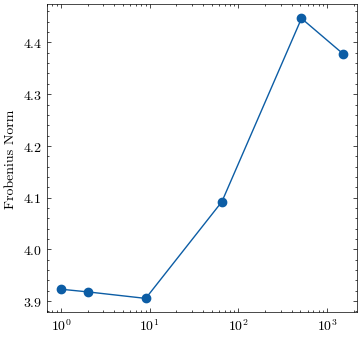

In [8]:
if hyp_dict['chosen_network'] == "dmpn":
    if net_params["input_layer_add"]:
        fignorm, axsnorm = plt.subplots(1,1,figsize=(4,4))
        axsnorm.plot(counter_lst, [np.linalg.norm(Winput_matrix) for Winput_matrix in Winput_lst], "-o")
        axsnorm.set_xscale("log")
        axsnorm.set_ylabel("Frobenius Norm")

In [9]:
# sanity check, if W_freeze, then the recorded W matrix for the modulation layer should not be changed
if net_params["ml_params"]["W_freeze"]: 
    assert np.allclose(Wall_lst[-1][0], Wall_lst[0][0])

if net_params["input_layer_bias"]: 
    assert net_params["input_layer_add"] is True 

Done!


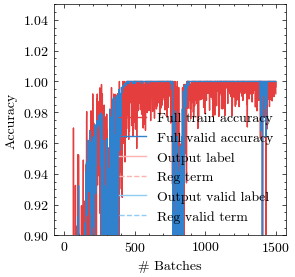

In [10]:
if train:
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    ax.plot(net.hist['iters_monitor'][1:], net.hist['train_acc'][1:], color=c_vals[0], label='Full train accuracy')
    ax.plot(net.hist['iters_monitor'][1:], net.hist['valid_acc'][1:], color=c_vals[1], label='Full valid accuracy')
    if net.weight_reg is not None:
        ax.plot(net.hist['iters_monitor'], net.hist['train_loss_output_label'], color=c_vals_l[0], zorder=-1, label='Output label')
        ax.plot(net.hist['iters_monitor'], net.hist['train_loss_reg_term'], color=c_vals_l[0], zorder=-1, label='Reg term', linestyle='dashed')
        ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_output_label'], color=c_vals_l[1], zorder=-1, label='Output valid label')
        ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_reg_term'], color=c_vals_l[1], zorder=-1, label='Reg valid term', linestyle='dashed')
    
    # ax.set_yscale('log')
    ax.legend()
    ax.set_ylim([0.90, 1.05])
    # ax.set_ylabel('Loss ({})'.format(net.loss_type))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('# Batches')
    plt.savefig(f"./twotasks/loss_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)
    
print('Done!')

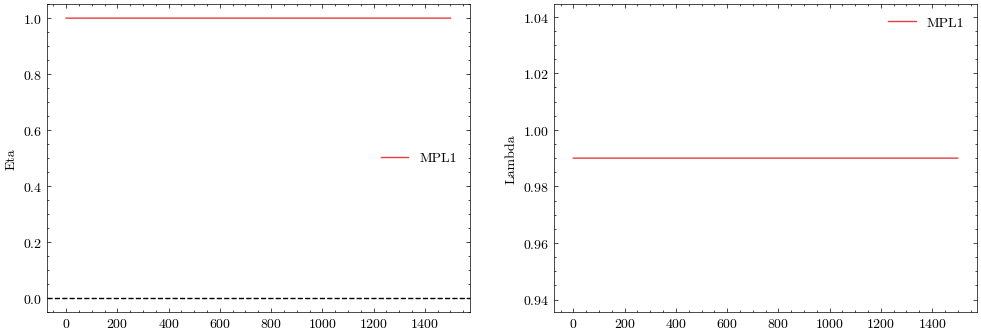

In [11]:
if train:
    net_helpers.net_eta_lambda_analysis(net, net_params, hyp_dict)

In [12]:
use_finalstage = False
if use_finalstage:
    # plotting output in the validation set
    net_out, db = net.iterate_sequence_batch(test_input, run_mode='track_states')
    W_output = net.W_output.detach().cpu().numpy()

    W_all_ = []
    for i in range(len(net.mp_layers)):
        W_all_.append(net.mp_layers[i].W.detach().cpu().numpy())
    W_ = W_all_[0]
    
else:
    # ind = len(marker_lst)-1 
    ind = -1
    # network_at_percent = (marker_lst[ind]+1)/train_params['n_datasets']*100
    # print(f"Using network at {network_at_percent}%")
    # by default using the first test_input 
    net_out = netout_lst[0][ind]
    db = db_lst[0][ind]
    W_output = Woutput_lst[ind]
    W_ = Wall_lst[ind][0]

In [13]:
def plot_input_output(test_input_np, net_out, test_output_np, test_task=None, tag="", batch_num=5):
    """
    """
    test_input_np = helper.to_ndarray(test_input_np)
    net_out = helper.to_ndarray(net_out)
    test_output_np = helper.to_ndarray(test_output_np)
    
    fig_all, axs_all = plt.subplots(batch_num,2,figsize=(4*2,batch_num*2))
    
    if test_output_np.shape[-1] == 1:
        for batch_idx, ax in enumerate(axs):
            ax.plot(net_out[batch_idx, :, 0], color=c_vals[batch_idx])
            ax.plot(test_output_np[batch_idx, :, 0], color=c_vals_l[batch_idx])
    
    else:
        for batch_idx in range(batch_num):
            for out_idx in range(test_output_np.shape[-1]):
                axs_all[batch_idx,0].plot(net_out[batch_idx, :, out_idx], color=c_vals[out_idx], label=out_idx)
                axs_all[batch_idx,0].plot(test_output_np[batch_idx, :, out_idx], color=c_vals_l[out_idx], linewidth=5, alpha=0.5)
                if test_task is not None: 
                    axs_all[batch_idx,0].set_title(f"{task_params['rules'][test_task[batch_idx]]}; {tag}")
                axs_all[batch_idx,0].legend()
    
            input_batch = test_input_np[batch_idx,:,:]
            if task_params["randomize_inputs"]: 
                input_batch = input_batch @ np.linalg.pinv(task_params["randomize_matrix"])
            for inp_idx in range(input_batch.shape[-1]):
                axs_all[batch_idx,1].plot(input_batch[:,inp_idx], color=c_vals[inp_idx], label=inp_idx)
                if test_task is not None: 
                    axs_all[batch_idx,1].set_title(f"{task_params['rules'][test_task[batch_idx]]}; {tag}")
                axs_all[batch_idx,1].legend()

    for ax in axs_all.flatten(): 
        ax.set_ylim([-2, 2])
    fig_all.tight_layout()
    fig_all.savefig(f"./twotasks/lowD_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_seed{seed}_{hyp_dict['addon_name']}_{tag}.png", dpi=300)

    return fig_all, axs_all

(<Figure size 800x1000 with 10 Axes>,
 array([[<Axes: title={'center': 'delayanti; '}>,
         <Axes: title={'center': 'delayanti; '}>],
        [<Axes: title={'center': 'delayanti; '}>,
         <Axes: title={'center': 'delayanti; '}>],
        [<Axes: title={'center': 'delayanti; '}>,
         <Axes: title={'center': 'delayanti; '}>],
        [<Axes: title={'center': 'delayanti; '}>,
         <Axes: title={'center': 'delayanti; '}>],
        [<Axes: title={'center': 'delaygo; '}>,
         <Axes: title={'center': 'delaygo; '}>]], dtype=object))

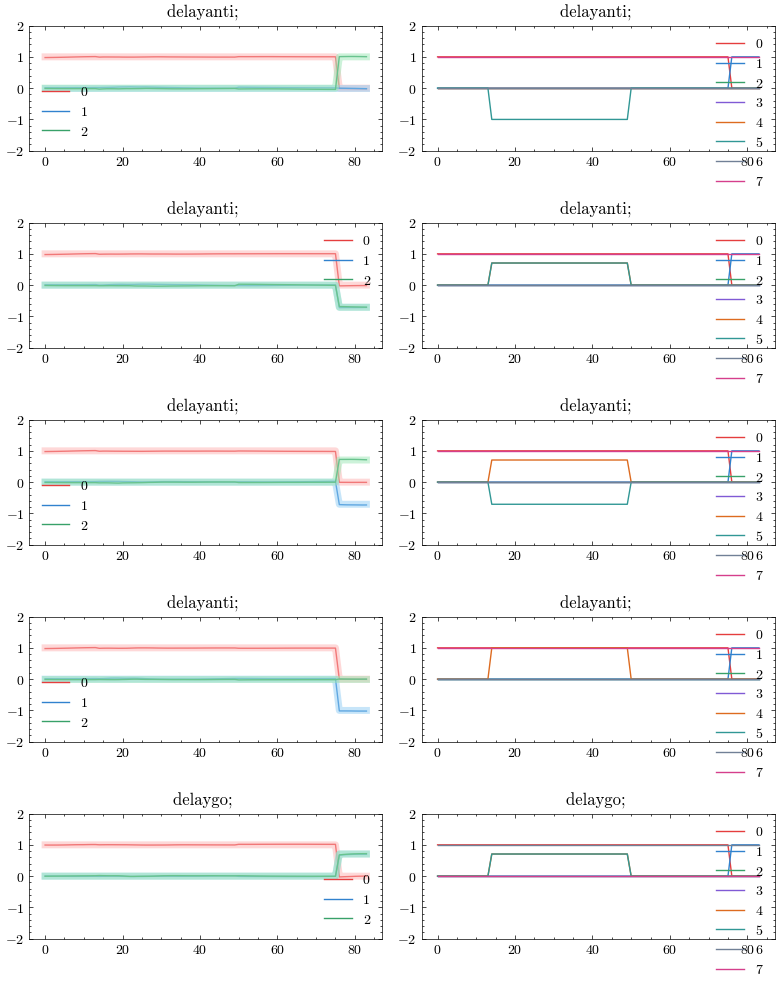

In [14]:
plot_input_output(test_input_np, net_out, test_output_np, test_task, tag="")

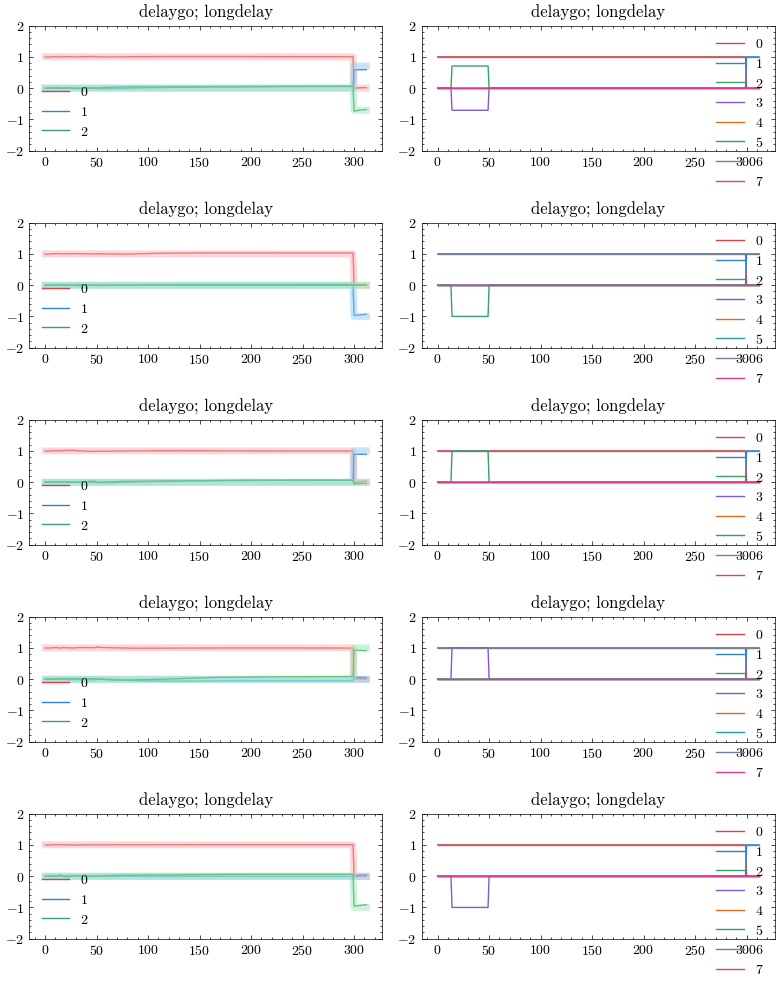

In [15]:
figld, axsld = plot_input_output(test_input_longdelay, netout_lst[3][ind], test_output_longdelay, 
                                 test_task_longdelay, tag="longdelay")

In [ ]:
figlr, axslr = plot_input_output(test_input_longresponse, netout_lst[4][ind], test_output_longresponse, 
                                 test_task_longresponse, tag="longresponse")

In [ ]:
figls, axsls = plot_input_output(test_input_longstimulus, netout_lst[2][ind], test_output_longstimulus, 
                                 test_task_longstimulus, tag="longstimulus")

In [ ]:
figlf, axslf = plot_input_output(test_input_longfixation, netout_lst[1][ind], test_output_longfixation, 
                                 test_task_longfixation, tag="longfixation")

In [ ]:
def dimensionality_measure(W):
    """
    Dimensionality in recurrent spiking networks: Global trends in activity and local origins in
    connectivity (Equation 3)
    "The dimensionality is a weighted measure of the number of axes explored by that cloud"
    Recanatesi, et al., 2019
    return value in range of (0, 1]
    """
    covW = np.cov(W)
    assert covW.shape[0] == n_hidden
    eigenvalues, eigenvectors = np.linalg.eig(covW)
    numerator = np.sum(eigenvalues) ** 2
    denominator = np.sum(eigenvalues ** 2)
    return (numerator / denominator) / W.shape[0]

In [ ]:
def make_label_task_comb(task_params, test_trials, test_task, color_by="stim"):
    """
    """
    labels_resp, labels_stim = generate_response_stimulus(task_params, test_trials)
    labels = labels_stim if color_by == "stim" else labels_resp
    # pair: [label_first_dim, task_id] for each trial
    return np.column_stack((labels[:, 0], test_task))

label_task_comb_longdelay = make_label_task_comb(
    task_params_longdelay, test_trials_longdelay, test_task_longdelay, color_by=color_by
)

label_task_comb_longresponse = make_label_task_comb(
    task_params_longresponse, test_trials_longresponse, test_task_longresponse, color_by=color_by
)

label_task_comb_longstimulus = make_label_task_comb(
    task_params_longstimulus, test_trials_longstimulus, test_task_longstimulus, color_by=color_by
)

label_task_comb_longfixation = make_label_task_comb(
    task_params_longfixation, test_trials_longfixation, test_task_longfixation, color_by=color_by
)

label_task_comb = make_label_task_comb(
    task_params, test_trials, test_task, color_by=color_by
)

In [ ]:
label_task_comb_longdelay.shape

In [ ]:
def sample_non_nan(arr, k):
    """
    Pick `k` distinct (non-NaN) numbers from a 2-D NumPy array.
    """
    pool = arr[~np.isnan(arr)]            # flatten & keep only real numbers
    if k > pool.size:                     # ensure enough unique values
        raise ValueError("k exceeds number of non-NaN entries.")
    return np.random.choice(pool, k, replace=False).tolist()

In [ ]:
def analyze_similarity(Ms_orig, hs, net_params, label_task_comb, checktime, compare="modulation"): 
    """
    """
    inverse_modulation_ss_dt = []
    inverse_modulation_sr_dt = []
    inverse_modulation_st_ds = [[], []]
    modulation_save = [[],[]]

    # same stimulus (effectively anti-response), different task
    for k in range(8):
        ind1 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [k, 0])]
        ind2 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [k, 1])]
        ll = min(len(ind1), len(ind2))

        if net_params["input_layer_add"]:
            win = net.W_initial_linear.weight.data.detach().cpu().numpy()
        else: 
            win = None 
        
        if compare == "modulation": 
            Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:]) @ win)[:,0].flatten() if win is not None 
                                   else (Ms_orig[ind1[i],checktime,:,:])[:,0].flatten() for i in range(ll)]
            Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:]) @ win)[:,0].flatten() if win is not None 
                                   else (Ms_orig[ind2[i],checktime,:,:])[:,0].flatten() for i in range(ll)]
        elif compare == "hidden": 
            Ms1_change_stimulus = [hs[ind1[i],checktime,:].flatten() for i in range(ll)]
            Ms2_change_stimulus = [hs[ind2[i],checktime,:].flatten() for i in range(ll)]
        
        inverse_modulation_ss_dt.append(np.mean(
            [1 - cosine(Ms1_change_stimulus[i], Ms2_change_stimulus[j]) 
             for i in range(len(Ms1_change_stimulus)) 
             for j in range(len(Ms2_change_stimulus))]
        ))

        modulation_save[0].append(Ms1_change_stimulus)
        modulation_save[1].append(Ms2_change_stimulus)

    # same response, different task 
    for k in range(8):
        ind1 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [k, 0])]
        ind2 = [i for i, lst in enumerate(label_task_comb) if np.array_equal(lst, [(k + 4) % 8, 1])]
        ll = min(len(ind1), len(ind2))

        if compare == "modulation": 
            Ms1_change_stimulus = [((Ms_orig[ind1[i],checktime,:,:]) @ win)[:,0].flatten() if win is not None 
                                   else ((Ms_orig[ind1[i],checktime,:,:]))[:,0].flatten() for i in range(ll)]
            Ms2_change_stimulus = [((Ms_orig[ind2[i],checktime,:,:]) @ win)[:,0].flatten() if win is not None 
                                   else ((Ms_orig[ind2[i],checktime,:,:]))[:,0].flatten() for i in range(ll)]
        elif compare == "hidden": 
            Ms1_change_stimulus = [hs[ind1[i],checktime,:].flatten() for i in range(ll)]
            Ms2_change_stimulus = [hs[ind2[i],checktime,:].flatten() for i in range(ll)]
        
        inverse_modulation_sr_dt.append(np.mean(
            [1 - cosine(Ms1_change_stimulus[i], Ms2_change_stimulus[j]) 
             for i in range(len(Ms1_change_stimulus)) 
             for j in range(len(Ms2_change_stimulus))]
        ))

    # same task, different stimulus 
    repeat = 100
    modulation_matrices_all = [] 
    for _ in range(repeat): 
        modulation_matrices = [
            np.full((len(modulation_save[0]), len(modulation_save[0])), np.nan), 
            np.full((len(modulation_save[0]), len(modulation_save[0])), np.nan)
        ]
        
        for i in range(len(modulation_save[0])):
            for j in range(i+1, len(modulation_save[0])):
                modulation_matrices[0][i,j] = 1 - cosine(random.choice(modulation_save[0][i]), random.choice(modulation_save[0][j]))
                modulation_matrices[1][i,j] = 1 - cosine(random.choice(modulation_save[1][i]), random.choice(modulation_save[1][j]))

        try: 
            modulation_matrices_all.append([np.nanmean(sample_non_nan(modulation_matrices[0], 8)),
                                            np.nanmean(sample_non_nan(modulation_matrices[1], 8))])
        except Exception as e:
            modulation_matrices_all.append([np.nan, np.nan])

    modulation_matrices_all = np.array(modulation_matrices_all)

    result = [[np.mean(inverse_modulation_ss_dt), np.std(inverse_modulation_ss_dt)], 
              [np.mean(inverse_modulation_sr_dt), np.std(inverse_modulation_sr_dt)], 
              [np.mean(modulation_matrices_all[:,0]), np.std(modulation_matrices_all[:,0])], 
              [np.mean(modulation_matrices_all[:,1]), np.std(modulation_matrices_all[:,1])]]

    return result

In [ ]:
# here db is selected based on learning stage selection 

layer_index = 0 # 1 layer MPN 
if net_params["input_layer_add"]:
    layer_index += 1 
    
def modulation_extraction(test_input, db, layer_index, cuda=False):
    """
    Extracts modulation tensors from `db` and returns:
        Ms:      (batch, seq, features) reshaped version of M
        Ms_orig: original M (no reshape)
        hs:      (batch, seq, features) reshaped version of hidden
        bs:      bias vector/matrix as-is (or concatenated if list)
    """

    def _to_numpy(x):
        # Convert torch.Tensor -> numpy, otherwise np.asarray
        try:
            import torch
            if isinstance(x, torch.Tensor):
                return x.detach().cpu().numpy()
        except Exception:
            pass
        return np.asarray(x)

    def _concat_last(x):
        # If list/tuple of arrays: concatenate on last axis; else return as-is
        return np.concatenate(x, axis=-1) if isinstance(x, (list, tuple)) else x

    n_batch, max_seq_len = test_input.shape[0], test_input.shape[1]

    # M
    M_raw = _concat_last(_to_numpy(db[f"M{layer_index}"]))
    Ms = M_raw.reshape(n_batch, max_seq_len, -1)
    Ms_orig = M_raw  # unreshaped

    # b
    bs = _concat_last(_to_numpy(db[f"b{layer_index}"]))

    # hidden
    H_raw = _concat_last(_to_numpy(db[f"hidden{layer_index}"]))
    hs = H_raw.reshape(n_batch, max_seq_len, -1)

    return Ms, Ms_orig, hs, bs

In [ ]:
# across training stage
result_attractor_all_h, result_attractor_all_m = [], []
pr_all = [] 
test_input_long_all = [test_input, test_input_longfixation, test_input_longstimulus, 
                       test_input_longdelay, test_input_longresponse]
label_task_comb_long_all = [label_task_comb, label_task_comb_longfixation, label_task_comb_longstimulus, 
                            label_task_comb_longdelay, label_task_comb_longresponse]
# register the timestamps information for different long periods
time_stamps_usual, time_stamps_longfixation, time_stamps_longstimulus, time_stamps, time_stamps_longresponse,  = {}, {}, {}, {}, {}

for i in range(5): 
    for db_attractor in db_lst[i]:
        _, M_long, h_long, _, = modulation_extraction(test_input_long_all[i], db_attractor, layer_index)
    
        prs = [dimensionality_measure(h_long[i,:,:].T) for i in range(h_long.shape[0])]
        
        if i == 0: 
            pr_all.append([np.mean(prs), np.std(prs)])
        
        # to handle noise, find the time when fixation is off
        checktime_sample = test_input_long_all[i][0,:,0].detach().cpu()
        mask = checktime_sample < 0.5                          
        idx = torch.nonzero(mask, as_tuple=False) 
        checktime_attractor = idx[0].item()  

        if i == 3: 
            time_stamps["delay_end"] = checktime_attractor - 2 # a little bit before the fixation off
        elif i == 4:
            time_stamps_longresponse["delay_end"] = checktime_attractor - 2
        elif i == 0: 
            time_stamps_usual["delay_end"] = checktime_attractor - 2
        elif i == 2: 
            time_stamps_longstimulus["delay_end"] = checktime_attractor - 2
        elif i == 1:
            time_stamps_longfixation["delay_end"] = checktime_attractor - 2

        if i == 0: 
            result_attractor_m = analyze_similarity(M_long, h_long, net_params, label_task_comb_long_all[i], 
                                                  checktime=checktime_attractor, compare="modulation")
            result_attractor_h = analyze_similarity(M_long, h_long, net_params, label_task_comb_long_all[i], 
                                                  checktime=checktime_attractor, compare="hidden")
        
            result_attractor_all_h.append(result_attractor_m)
            result_attractor_all_m.append(result_attractor_h)

In [ ]:
# pr_all = np.array(pr_all)
# figpr, axspr = plt.subplots(1,1,figsize=(6,3))
# axspr.plot(counter_lst, pr_all[:,0], "-o", color=c_vals[0])
# axspr.fill_between(counter_lst, pr_all[:,0]-pr_all[:,1], pr_all[:,0]+pr_all[:,1], color=c_vals_l[0], alpha=0.5)
# axspr.set_xscale("log")
# axspr.set_xlabel("# Dataset", fontsize=15)
# axspr.set_ylabel("Normalized \nParticipation Ratio", fontsize=15)
# axspr.tick_params(axis="y", labelsize=12)
# axspr.tick_params(axis="x", labelsize=12)
# figpr.savefig(f"./twotasks/pr_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [ ]:
figattractor, axsattractor = plt.subplots(1, 2, figsize=(8, 4))

break_names = [
    "same stimulus",
    "same response",
    "task 1 different stimulus",
    "task 2 different stimulus",
]

def plot_mean_std(ax, x, mean, std, color, fill_color, label):
    ax.plot(x, mean, "-o", color=color, label=label)
    ax.fill_between(x, np.asarray(mean) - np.asarray(std), np.asarray(mean) + np.asarray(std),
                    alpha=0.5, color=fill_color)

# each entry: (results, axis_index)
panels = [
    (result_attractor_all_h, 0),
    (result_attractor_all_m, 1),
]

n_groups = len(result_attractor_all_h[0])  # same as your original len(result_attractor_all[0])

for i in range(n_groups):
    for results, ax_idx in panels:
        mean = [rs[i][0] for rs in results]
        std  = [rs[i][1] for rs in results]
        plot_mean_std(
            axsattractor[ax_idx],
            counter_lst,
            mean,
            std,
            color=c_vals[i],
            fill_color=c_vals_l[i],
            label=break_names[i],
        )

for ax in axsattractor:
    ax.set_xscale("log")
    ax.legend()

figattractor.tight_layout()
figattractor.savefig(
    f"./twotasks/attractor_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png",
    dpi=300,
)

In [ ]:
# across different timestamp 
def time_stamp_extract(test_input_long, time_stamps):
    stimulus_end = None 
    chosen_batch = 0
    while stimulus_end is None: 
        try: 
            input_part = test_input_long[chosen_batch,:,2:2+4].detach().cpu().numpy()
            input_part_sum = np.sum(input_part, axis=1)
            stimulus_end = np.where(input_part_sum > 0.5)[0][-1]
            stimulus_start = np.where(input_part_sum > 0.5)[0][0] - 1
        except IndexError: 
            chosen_batch += 1
    
    time_stamps["stimulus_start"] = stimulus_start
    time_stamps["stimulus_end"] = stimulus_end
    time_stamps["delay_start"] = stimulus_end + 1
    time_stamps["trial_end"] = len(input_part_sum) - 1
    time_stamps["fixation_end"] = stimulus_start - 1
    time_stamps["fixation_start"] = 0 

    return time_stamps

time_stamps = time_stamp_extract(test_input_longdelay, time_stamps)
time_stamps_longresponse = time_stamp_extract(test_input_longresponse, time_stamps_longresponse)
time_stamps_usual = time_stamp_extract(test_input, time_stamps_usual)
time_stamps_longstimulus = time_stamp_extract(test_input_longstimulus, time_stamps_longstimulus)
time_stamps_longfixation = time_stamp_extract(test_input_longfixation, time_stamps_longfixation)

print(f"time_stamps: {time_stamps}")
print(f"time_stamps_longresponse: {time_stamps_longresponse}")
print(f"time_stamps_usual: {time_stamps_usual}")
print(f"time_stamps_longstimulus: {time_stamps_longstimulus}")
print(f"time_stamps_longfixation: {time_stamps_longfixation}")

In [ ]:
def figure2A_pca_fve(
    H,
    task_id,
    periods,
    k=2,
    max_pcs=10,
    center="global",          # {"global", "none"}
    flatten="trial_time",     # currently only "trial_time"
    dtype=np.float64,
    return_cross_task=True,   # NEW
):
    """
    Figure 2A-style cross-period PCA explained-variance analysis.

    NEW: optionally compute a cross-task, cross-period FVE matrix across all (task, period)
         pairs and return it as `fve_k_all` (Q x Q). If you have 2 tasks each with P periods,
         Q=2P and fve_k_all is 2P x 2P.

    Returns
    -------
    results : dict
        results[task] = {
            "period_names": list[str] length P_task,
            "fve_k": np.ndarray (P_task, P_task), rows=target period X, cols=basis period Y,
            "evr_curves": np.ndarray (P_task, max_pcs),
            "pca": {period_name: {"components": (N, r), "singular_values": (r,), "mean": (N,), "evr": (r,)}}
        }
        plus, if return_cross_task:
        results["__cross_task__"] = {
            "labels": list[tuple(task, period_name)] length Q,
            "fve_k_all": np.ndarray (Q, Q), rows=target (task,period), cols=basis (task,period)
        }
    """
    # --- helper: convert torch -> numpy without requiring torch import
    if hasattr(H, "detach"):
        H_np = H.detach().cpu().numpy()
    else:
        H_np = np.asarray(H)
    H_np = H_np.astype(dtype, copy=False)

    task_id = np.asarray(task_id)
    B, T, N = H_np.shape

    def _get_period_matrix(H_task, t0, t1):
        X = H_task[:, t0:t1, :]  # (B_task, L, N)
        if flatten == "trial_time":
            X = X.reshape(-1, N)  # (B_task*L, N)
        else:
            raise ValueError(f"Unsupported flatten mode: {flatten}")
        return X

    def _center(X, mean=None):
        if center == "none":
            mu = np.zeros((X.shape[1],), dtype=X.dtype) if mean is None else mean
            return X, mu
        if mean is None:
            mu = X.mean(axis=0)
        return X - mu, mu

    def _pca_svd(X, r):
        """
        PCA via SVD on centered data X (M,N).
        Returns components V (N,r_eff), EVR (r_eff,), singular values (r_eff,).
        """
        U, S, Vt = np.linalg.svd(X, full_matrices=False)
        r_eff = min(r, Vt.shape[0])
        V = Vt[:r_eff, :].T  # (N, r_eff)
        S = S[:r_eff]

        M = X.shape[0]
        denom = (np.sum(X * X) / max(M - 1, 1))
        evals = (S * S) / max(M - 1, 1)
        evr = evals / denom if denom > 0 else np.zeros_like(evals)
        return V, S, evr

    def _fve_project(X, V):
        """
        Fraction of variance explained by projecting X onto span(V).
        X should be centered consistently with the PCA basis.
        V: (N, r)
        """
        tot = np.sum(X * X)
        if tot <= 0:
            return 0.0
        XV = X @ V
        Xhat = XV @ V.T
        num = np.sum(Xhat * Xhat)
        return float(num / tot)

    # -----------------------------
    # Per-task results (unchanged)
    # -----------------------------
    results = {}

    # For cross-task aggregation (NEW)
    all_labels = []          # list of (task, period_name)
    all_Xc = {}              # (task, period) -> centered matrix
    all_Vk = {}              # (task, period) -> top-k basis (N, k_eff)

    for task, per_dict in periods.items():
        idx = np.where(task_id == task)[0]
        if idx.size == 0:
            continue

        H_task = H_np[idx, :, :]  # (B_task, T, N)

        period_names = list(per_dict.keys())
        P = len(period_names)

        pca_info = {}
        X_period_centered = {}

        for pname in period_names:
            t0, t1 = per_dict[pname]
            if not (0 <= t0 < t1 <= T):
                raise ValueError(f"[{task}:{pname}] invalid period bounds {(t0,t1)} for T={T}")
            X = _get_period_matrix(H_task, t0, t1)
            Xc, mu = _center(X)
            X_period_centered[pname] = Xc

            V, S, evr = _pca_svd(Xc, r=max(max_pcs, k))
            pca_info[pname] = {
                "components": V,
                "singular_values": S,
                "mean": mu,
                "evr": evr,
            }

            # NEW: cache (task, period) for cross-task matrix
            if return_cross_task:
                key = (task, pname)
                all_labels.append(key)
                all_Xc[key] = Xc
                k_eff = min(k, V.shape[1])
                all_Vk[key] = V[:, :k_eff]  # top-k PCs for this (task, period)

        # intra-task cross-period FVE matrix (same as before)
        fve_k = np.zeros((P, P), dtype=dtype)
        for i, px in enumerate(period_names):
            Xc = X_period_centered[px]
            for j, py in enumerate(period_names):
                V = pca_info[py]["components"]
                r_eff = min(k, V.shape[1])
                fve_k[i, j] = _fve_project(Xc, V[:, :r_eff])

        # per-period EVR curves (same as before)
        evr_curves = np.zeros((P, max_pcs), dtype=dtype)
        for i, pname in enumerate(period_names):
            evr = pca_info[pname]["evr"]
            evr_curves[i, :min(max_pcs, evr.shape[0])] = evr[:min(max_pcs, evr.shape[0])]

        results[task] = {
            "period_names": period_names,
            "fve_k": fve_k,
            "evr_curves": evr_curves,
            "pca": pca_info,
        }

    # --------------------------------------------
    # Cross-task, cross-period FVE matrix (NEW)
    # --------------------------------------------
    if return_cross_task:
        # Keep a stable order (task insertion order from `periods`, then period order in each task)
        # all_labels already appended in that order.

        Q = len(all_labels)
        fve_k_all = np.zeros((Q, Q), dtype=dtype)

        for i, key_x in enumerate(all_labels):       # target
            Xc = all_Xc[key_x]
            for j, key_y in enumerate(all_labels):   # basis
                Vk = all_Vk[key_y]
                fve_k_all[i, j] = _fve_project(Xc, Vk)

        results["__cross_task__"] = {
            "labels": all_labels,      # rows/cols correspond to this list
            "fve_k_all": fve_k_all,    # (Q, Q); for 2 tasks with P periods each => 2P x 2P
        }

    return results


In [ ]:
H = db["hidden1"]
M = db["M1"].reshape(db["M1"].shape[0], db["M1"].shape[1], -1)
task_id = test_task
periods = time_stamp_extract(test_input, time_stamps_usual)
print(f"periods: {periods}")
periods_ = {
    0: {"context": (0, periods["stimulus_start"]-1), 
          "stim": (periods["stimulus_start"], periods["stimulus_end"]), 
          "delay": (periods["delay_start"], periods["delay_end"]-1), 
          "resp": (periods["delay_end"], periods["trial_end"])}, 
    1: {"context": (0, periods["stimulus_start"]-1), 
          "stim": (periods["stimulus_start"], periods["stimulus_end"]), 
          "delay": (periods["delay_start"], periods["delay_end"]-1), 
          "resp": (periods["delay_end"], periods["trial_end"])}, 
}

In [ ]:
top_k = 2
print(f"H.shape: {H.shape}")
res_H = figure2A_pca_fve(H, task_id, periods_, k=top_k, max_pcs=10, center="None")

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(4*2,4))
for task_index in range(2):
    for period_index in range(4):
        evr_curve = res_H[task_index]["evr_curves"][period_index]
        period_name = res_H[task_index]["period_names"][period_index]
        cev = np.cumsum(evr_curve, axis=0)
        axs[task_index].plot([i+1 for i in range(len(cev))], cev, "-o", color=c_vals[period_index], label=period_name)
        
axs[0].set_ylabel("Go Task; Var. expl.", fontsize=15)
axs[1].set_ylabel("Anti Task; Var. expl.", fontsize=15)
for ax in axs:
    ax.set_xlabel("No. of PCs", fontsize=15)
    ax.legend(fontsize=12, frameon=True, loc="best")
fig.tight_layout()
fig.savefig(
    f"./twotasks/dimension_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png",
    dpi=300,
)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(4*2,4))
for task_index in range(2):
    fve_k = res_H[task_index]["fve_k"]
    sns.heatmap(fve_k, ax=axs[task_index], 
                xticklabels=res_H[task_index]["period_names"], 
                yticklabels=res_H[task_index]["period_names"],
                annot=True, fmt=".2f")
axs[0].set_title(f"Go Task, k={top_k}", fontsize=15)
axs[1].set_title(f"Anti Task, k={top_k}", fontsize=15)
fig.tight_layout()
fig.savefig(
    f"./twotasks/d_separate_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png",
    dpi=300,
)

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(4*1,4))
fve_k_all = res_H["__cross_task__"]["fve_k_all"]
labels_all = res_H["__cross_task__"]["labels"]

permute = [0,4,1,5,2,6,3,7]
fve_k_all = fve_k_all[np.ix_(permute, permute)]
labels_all = [labels_all[i] for i in permute]

labels_alt = ["Pro Context", "Anti Context", "Pro Stim", "Anti Stim",
             "Pro Memory", "Anti Memory", "Pro Response", "Anti Response"]

sns.heatmap(fve_k_all, ax=axs, 
            xticklabels=labels_alt,
            yticklabels=labels_alt,
            annot=True, fmt=".2f", vmin=0.0, vmax=1.0)

# axs.set_title(f"Go/Anti Task", fontsize=15)
fig.tight_layout()
fig.savefig(
    f"./twotasks/d_combine_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png",
    dpi=300,
)

In [ ]:
for ax in axsld.flatten():
    for pindex, period in enumerate(list(time_stamps.values())):
        ax.axvline(period, alpha=0.5, color=c_vals_d[pindex])
        
figld

In [ ]:
for ax in axslr.flatten():
    for pindex, period in enumerate(list(time_stamps_longresponse.values())):
        ax.axvline(period, alpha=0.5, color=c_vals_d[pindex])
        
figlr

In [ ]:
for ax in axsls.flatten():
    for pindex, period in enumerate(list(time_stamps_longstimulus.values())):
        ax.axvline(period, alpha=0.5, color=c_vals_d[pindex])
        
figls

In [ ]:
for ax in axslf.flatten():
    for pindex, period in enumerate(list(time_stamps_longfixation.values())):
        ax.axvline(period, alpha=0.5, color=c_vals_d[pindex])
        
figlf

In [ ]:
time_stamps

In [ ]:
compare_values = ["hidden", "modulation"]
for compare_value in compare_values: 
    _, M_end, h_end, _ = modulation_extraction(test_input, db_lst[0][-1], layer_index)
    result_attractor_end_all = {} 
    # all_keys = [k for k in time_stamps.keys() if k != "fixation_start"]
    all_keys = ["fixation_end", "stimulus_end", "delay_end", "trial_end"]
    for key in all_keys: 
        result_attractor = analyze_similarity(M_end, h_end, net_params, label_task_comb, 
                                              checktime=time_stamps_usual[key], compare=compare_value)
        result_attractor_end_all[key] = result_attractor
    
    figattractorend, axsattractorend = plt.subplots(1,1,figsize=(8,4))
    for i in range(len(result_attractor_end_all["trial_end"])): 
        mean, std = [rs[i][0] for rs in result_attractor_end_all.values()], [rs[i][1] for rs in result_attractor_end_all.values()]
        stages_counter = [i for i in range(len(result_attractor_end_all))]
        axsattractorend.plot(stages_counter, mean, "-o", color=c_vals[i], label=f"{break_names[i]}")
        axsattractorend.fill_between(stages_counter, [mean[i]-std[i] for i in range(len(mean))],\
                                  [mean[i]+std[i] for i in range(len(mean))], alpha=0.5, color=c_vals_l[i])
        
    axsattractorend.set_xticks(stages_counter)
    axsattractorend.set_xticklabels(list(result_attractor_end_all.keys()), rotation=45, ha="right", fontsize=12)
    axsattractorend.legend(fontsize=12, frameon=True, loc="best")
    axsattractorend.set_ylabel(f"Cosine similarity of {compare_value}", fontsize=12)
    figattractorend.tight_layout()
    figattractorend.savefig(f"./twotasks/attractor_stage_{compare_value}_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

In [ ]:
from itertools import chain

def input_interpolation(test_input_long, test_output_long, label_task_comb_long, expand_stimulus=True):
    """
    """
    assert test_input_long.shape[0] == label_task_comb_long.shape[0] 
    pro_task, anti_task = {}, {} 
    pro_task_answer, anti_task_answer = {}, {} 
    for k in range(8): 
        ind1 = [i for i, lst in enumerate(label_task_comb_long) if np.array_equal(lst, [k, 0])]
        ind1_sample = ind1[0]
        pro_task[k] = test_input_long[ind1_sample,:,:]
        pro_task_answer[k] = test_output_long[ind1_sample,:,:]

        ind2 = [i for i, lst in enumerate(label_task_comb_long) if np.array_equal(lst, [k, 1])]
        ind2_sample = ind2[0]
        anti_task[k] = test_input_long[ind2_sample,:,:]
        anti_task_answer[k] = test_output_long[ind2_sample,:,:]

    # expand with some unseen stimulus
    if expand_stimulus:
        base_len = len(pro_task)          # original size (8)
        for i in range(base_len):
            i1, i2 = i % 8, (i + 1) % 8   # wrap-around indexing
    
            # input dictionaries
            pro_task[base_len + i]  = (pro_task[i1]        + pro_task[i2])        / 2
            anti_task[base_len + i] = (anti_task[i1]       + anti_task[i2])       / 2
    
            # answer dictionaries
            pro_task_answer[base_len + i]  = (pro_task_answer[i1]        + pro_task_answer[i2])        / 2
            anti_task_answer[base_len + i] = (anti_task_answer[i1]       + anti_task_answer[i2])       / 2

        # re-sort the input and output in an interleaved way 
        interleaved_keys = [k for pair in zip(range(base_len), range(base_len, 2*base_len)) for k in pair]

        pro_task = {k: pro_task[k] for k in interleaved_keys}
        anti_task = {k: anti_task[k] for k in interleaved_keys}
        pro_task_answer = {k: pro_task_answer[k] for k in interleaved_keys}
        anti_task_answer = {k: anti_task_answer[k] for k in interleaved_keys}
    
    n = 20 
    alpha_lst = [i/n for i in range(n+1)]

    stacked_pro = torch.stack([pro_task[k] for k in sorted(pro_task)]) 
    stacked_anti = torch.stack([anti_task[k] for k in sorted(anti_task)])
    stacked_pro_answer = torch.stack([pro_task_answer[k] for k in sorted(pro_task_answer)]) 
    stacked_anti_answer = torch.stack([anti_task_answer[k] for k in sorted(anti_task_answer)])
    
    stacked_interpolation = [alpha_lst[i] * stacked_pro + (1 - alpha_lst[i]) * stacked_anti 
                             for i in range(len(alpha_lst))]
    stacked_interpolation_ans = [alpha_lst[i] * stacked_pro_answer + (1 - alpha_lst[i]) * stacked_anti_answer for i in range(len(alpha_lst))]               

    return alpha_lst, stacked_interpolation, stacked_interpolation_ans

alpha_lst, stacked_interpolation_ld, stacked_interpolation_answer_ld = input_interpolation(test_input_longdelay, 
                                                                                           test_output_longdelay, 
                                                                                           label_task_comb_longdelay, 
                                                                                           expand_stimulus=False)

_, stacked_interpolation_lr, stacked_interpolation_answer_lr = input_interpolation(test_input_longresponse, 
                                                                                   test_output_longresponse, 
                                                                                   label_task_comb_longresponse, 
                                                                                   expand_stimulus=False)

_, stacked_interpolation_ls, stacked_interpolation_answer_ls = input_interpolation(test_input_longstimulus, 
                                                                                   test_output_longstimulus, 
                                                                                   label_task_comb_longstimulus, 
                                                                                   expand_stimulus=False)

_, stacked_interpolation_lf, stacked_interpolation_answer_lf = input_interpolation(test_input_longfixation, 
                                                                                   test_output_longfixation, 
                                                                                   label_task_comb_longfixation, 
                                                                                   expand_stimulus=False)

In [ ]:
time_stamps

In [ ]:
time_stamp_input_map = [
    [time_stamps_usual, test_input, "normal", 0, "delay_end", label_task_comb], 
    [time_stamps, test_input_longdelay, "longdelay", 3, "delay_end", label_task_comb_longdelay], 
    [time_stamps_longstimulus, test_input_longstimulus, "longstimulus", 2, "stimulus_end", label_task_comb_longstimulus], 
    [time_stamps_longresponse, test_input_longresponse, "longresponse", 4, "trial_end", label_task_comb_longresponse],
    [time_stamps_longfixation, test_input_longfixation, "longfixation", 1, "fixation_end", label_task_comb_longfixation]
]

In [ ]:
def l2_consecutive_diff(X: np.ndarray) -> np.ndarray:
    """
    X: (T, N)
    returns: (T-1,) array, per-time-step L2 difference
    """
    d = np.diff(X, axis=0)          # (T-1, N)
    return np.linalg.norm(d, axis=1)

In [ ]:
for time_stamp_long, test_input_long, sname, db_index, end_time_name, _ in time_stamp_input_map: 
    end_time = time_stamp_long[end_time_name]
    _, M, h, _ = modulation_extraction(test_input_long, db_lst[db_index][-1], layer_index)
    M = M.reshape(M.shape[0], M.shape[1], -1)
    diff_h_all = np.array([l2_consecutive_diff(h[batch_size]) for batch_size in range(h.shape[0])])
    diff_M_all = np.array([l2_consecutive_diff(M[batch_size]) for batch_size in range(M.shape[0])])

    fig, axs = plt.subplots(1,2,figsize=(4*2,4))
    axs[0].plot(np.mean(diff_h_all, axis=0), color=c_vals[0])
    axs[1].plot(np.mean(diff_M_all, axis=0), color=c_vals[0])
    for ax in axs:
        ax.set_xlabel("Time Steps", fontsize=12)
        ax.set_yscale("log")
        ax.axvline(end_time, color=c_vals[1], linewidth=2)
        ax.set_title(sname, fontsize=15)
    axs[0].set_ylabel("Hidden Per-Time-Step L2 Diff", fontsize=12)
    axs[1].set_ylabel("Modulation Per-Time-Step L2 Diff", fontsize=12)
    fig.tight_layout()
    fig.savefig(f"./twotasks/l2_timee_diff_seed{seed}_{hyp_dict['addon_name']}_{sname}.png", dpi=300)

In [ ]:
from matplotlib.lines import Line2D

projected_data_all = [] 

for time_stamp_long, test_input_long, sname, db_index, _, label_task_comb_long in time_stamp_input_map: 
    print(f"sname: {sname}; db_index: {db_index}")
    # 0 Red, 1 blue, 2 green, 3 purple, 4 orange, 5 teal, 6 gray, 7 pink, 8 yellow
    names = ["hidden", "modulation"]
        
    for name in names:
        fighs, axshs = plt.subplots(1,3,figsize=(5*3,5*1))
        
        PCA_downsample = 3
            
        Ms, Ms_orig, hs, bs = modulation_extraction(test_input_long, db_lst[db_index][-1], layer_index)
        batch_num = Ms_orig.shape[0]
        
        if name == "modulation": 
            data = Ms
        elif name == "hidden":
            data = hs 
            
        print(f"data.shape: {data.shape}")
        
        pca = PCA(n_components = PCA_downsample, random_state=42)
        n_activity = data.shape[-1] 
    
        activity_zero = np.zeros((1, n_activity))
        
        mask_task1 = label_task_comb_long[:,1] == 1
        mask_task0 = label_task_comb_long[:,0] == 0
                
        as_flat = data.reshape((-1, n_activity))    
        pca.fit(as_flat)
        
        total_ev_training = pca.explained_variance_ratio_.sum()  
    
        # if name == "hidden": 
        #     wout = net.W_output.detach().cpu().numpy() 
        #     wout_proj = pca.transform(wout) 
        
        as_pca = pca.transform(as_flat)
        projected_data = as_pca.reshape((data.shape[0], data.shape[1], -1))
        print(projected_data.shape)

        # save for the delay fixed point analysis
        if db_index == 3: 
            projected_data_all.append(projected_data)
            
        zeros_pca = pca.transform(activity_zero)
        
        combination = [(0, 1), (0, 2), (1, 2)]

        phases = [
            ("fix",   "fixation_start", "fixation_end", 1),
            ("stim",  "stimulus_start", "delay_start",  2),
            ("delay", "delay_start",    "delay_end",    3),
            ("resp",  "delay_end",      "trial_end",    4),
        ]
        
        # transition endpoints to highlight (end of each phase)
        # (key, marker index)
        transitions = [
            ("fixation_end", 1), # end of fixation
            ("delay_start", 2),  # end of stim
            ("delay_end",   3),  # end of delay
            ("trial_end",   4),  # end of resp
        ]

        period_markers = {
            "Fixation": 0,   # 'v'
            "Stimulus": 1,   # '*'
            "Delay":    2,   # 'x'
            "Response": 3,   
        }
        
        stim0 = time_stamp_long["stimulus_start"]
        trial_end = time_stamp_long["trial_end"]

        legend_handles = [
            Line2D(
                [0], [0],
                marker=markers_vals[idx],
                linestyle="None",
                markersize=10,
                markerfacecolor="k",
                markeredgecolor="k",
                label=label
            )
            for label, idx in period_markers.items()
        ]
        
        for i in range(batch_num):
            task = label_task_comb_longdelay[i, 1]
            if task not in (0, 1):
                continue
        
            color = c_vals[label_task_comb_longdelay[i, 0]]
            ls = linestyles[task]
            data = projected_data[i]
            seg = slice(stim0, trial_end)
        
            for ax, (a, b) in zip(axshs, combination):
                # full trajectory
                ax.plot(data[seg, a], data[seg, b], c=color, linestyle=ls, alpha=0.01)
        
                # phase point clouds
                for _, t0_key, t1_key, mk_idx in phases:
                    sl = slice(time_stamp_long[t0_key], time_stamp_long[t1_key])
                    ax.scatter(data[sl, a], data[sl, b],
                               c=color, marker=markers_vals[mk_idx], 
                               alpha=0.01 if sname != "normal" else 0.1)
        
                # highlight transition endpoints (single points)
                for t_key, mk_idx in transitions:
                    t = time_stamp_long[t_key] - 1  # end index of that period
                    ax.scatter([data[t, a]], [data[t, b]],
                               c=color,
                               marker=markers_vals[mk_idx],
                               alpha=0.8,      # much more visible
                               s=60,           # larger
                               linewidths=0.6,
                               zorder=10)
        
        # Set cosmetics once (not every batch)
        for ax, (a, b) in zip(axshs, combination):
            ax.set_xlabel(f"PCA {a+1}", fontsize=12)
            ax.set_ylabel(f"PCA {b+1}", fontsize=12)
            ax.set_title(f"name: {name}; sname: {sname}", fontsize=15)
            ax.legend(
                handles=legend_handles, 
                loc="upper right", 
                frameon=False
            )
            
        fighs.tight_layout()
        fighs.savefig(f"./twotasks/m_pca_{name}_seed{seed}_{hyp_dict['addon_name']}_{sname}.png", dpi=300)

In [ ]:
# import plotly.graph_objects as go

# for indd, projected_data in enumerate(projected_data_all): 
#     fig = go.Figure()
    
#     for i in range(batch_num):
#         data_batch = projected_data[i, :time_stamps["delay_end"], :]
#         fig.add_trace(
#             go.Scatter3d(
#                 x=data_batch[:,0], y=data_batch[:,1], z=data_batch[:,2],
#                 mode="lines",
#                 line=dict(width=2, color=c_vals[label_task_comb_longdelay[i,0]]),
#                 opacity=0.5,
#                 showlegend=False           
#             )
#         )
    
#     # origin point
#     fig.add_trace(
#         go.Scatter3d(
#             x=[zeros_pca[0, 0]], y=[zeros_pca[0, 1]], z=[zeros_pca[0, 2]],
#             mode="markers",
#             marker=dict(size=4, color="black"),
#             showlegend=False
#         )
#     )

#     zero_pt = zeros_pca[0]
    
#     # define the two spanning vesample_non_nanctors (from the origin)
#     v1 = wout_proj[0,:]
#     v2 = wout_proj[1,:]
    
#     # pick a side-length that matches your data’s overall scale
#     traj = projected_data[:, :time_stamps["delay_end"], :].reshape(-1, 3)
#     plane_half = 0.5 * np.linalg.norm(traj - zero_pt, axis=1).max()           
    
#     # build an (almost) orthonormal basis in the v1–v2 plane
#     u_hat = v1 / np.linalg.norm(v1)
#     v2_proj = v2 - v2.dot(u_hat) * u_hat      
#     v_hat = v2_proj / np.linalg.norm(v2_proj)
    
#     # four corners of a square patch centred at the origin
#     corners = np.array([
#         -plane_half*u_hat - plane_half*v_hat,
#          plane_half*u_hat - plane_half*v_hat,
#          plane_half*u_hat + plane_half*v_hat,
#         -plane_half*u_hat + plane_half*v_hat
#     ])
    
#     fig.add_trace(
#         go.Mesh3d(
#             x=corners[:, 0],
#             y=corners[:, 1],
#             z=corners[:, 2],
#             i=[0, 0],
#             j=[1, 2],
#             k=[2, 3],
#             opacity=0.25,
#             color="lightblue",
#             name="spanning plane",
#             showscale=False
#         )
#     )
    
#     fig.update_layout(
#         scene=dict(
#             xaxis_title="PCA 1",
#             yaxis_title="PCA 2",
#             zaxis_title="PCA 3"
#         ),
#         width=600,          
#         height=600,
#         margin=dict(l=0, r=0, t=40, b=0),
#         showlegend=False     
#     )
    
#     fig.show()

#     if indd == 0: 
#         endpoints = projected_data[:,time_stamps["delay_end"]+1,:]
#         figproj, axproj = plt.subplots(1,1,figsize=(4,4))
#         for ei in range(endpoints.shape[0]):
#             endpoint = endpoints[ei,:] - zero_pt
#             u_coord = endpoint.dot(u_hat)
#             v_coord = endpoint.dot(v_hat) 
#             endpoint_proj  = zero_pt + u_coord*u_hat + v_coord*v_hat
            
#             if label_task_comb_longdelay[ei,1] == 0: 
#                 color_index = label_task_comb_longdelay[ei,0] 
#             else: 
#                 color_index = (label_task_comb_longdelay[ei,0] + 4) % 8 
    
#             axproj.scatter(u_coord, v_coord, c=c_vals[color_index], alpha=0.1)
            
#         figproj.show()
        


In [ ]:
from matplotlib.colors import SymLogNorm
from scipy.spatial import ConvexHull   

def ring_length(pts: np.ndarray) -> float:
    """
    """
    diffs = np.diff(pts, axis=0, append=pts[:1])   # close the loop
    return np.linalg.norm(diffs, axis=1).sum()

def ring_volume_nd(pts: np.ndarray) -> float:
    """
    """
    T, D = pts.shape
    if T <= D:
        raise ValueError(
            f"Need at least D+1={D+1} non-coplanar points, got {T}."
        )

    hull = ConvexHull(pts)
    return hull.volume

def ring_volume_3d(pts: np.ndarray) -> float:
    """
    """
    if pts.shape[1] != 3:
        raise ValueError("ring_volume_3d expects a 3-D point set.")

    hull = ConvexHull(pts)                # triangulated convex surface
    return hull.volume                    # signed; take abs if needed

In [ ]:
time_stamps_longresponse

In [ ]:
# 0 Red, 1 blue, 2 green, 3 purple, 4 orange, 5 teal, 6 gray, 7 pink, 8 yellow
# 2025-12-30: this part effectively mapped to Figure 2f and 2h in Driscoll NN
stacked_interpolation_lst = [stacked_interpolation_ld, stacked_interpolation_lr, stacked_interpolation_ls, stacked_interpolation_lf]
time_stamps_lst = [time_stamps, time_stamps_longresponse, time_stamps_longstimulus, time_stamps_longfixation]
stacked_interpolation_name_lst = ["longdelay", "longresponse", "longstimulus", "longfixation"]
desire_period = [[time_stamps["delay_start"], time_stamps["delay_end"]], 
                 [time_stamps_longresponse["delay_end"], time_stamps_longresponse["trial_end"]],
                 [time_stamps_longstimulus["stimulus_start"], time_stamps_longstimulus["stimulus_end"]],
                 [time_stamps_longfixation["fixation_start"], time_stamps_longfixation["fixation_end"]]]

int_input_all = []
raw_data_ring_all, raw_data_ring_magnitude_all, projected_data_ring_all = [], [], []

for siindex, stacked_interpolation_ in enumerate(stacked_interpolation_lst):
    sname = stacked_interpolation_name_lst[siindex]
    print(f"sname: {sname}")
    
    names = ["hidden", "modulation"]
    
    raw_data_ring = [[], []] 
    raw_data_ring_magnitude = [[], []]
    projected_data_ring = [[], []]
    
    for nindex, name in enumerate(names):
        fighs, axshs = plt.subplots(1,3,figsize=(5*3,5*1))
        fighsadd, axshsadd = plt.subplots(1,3,figsize=(5*3,5*1))
        
        fig3dfix = go.Figure()

        fig3dfix.update_traces(
            selector=dict(type="scatter3d"),
            marker=dict(size=3),
            line=dict(width=2)
        )
        
        PCA_downsample = 3
        combination = [[0,1],[0,2],[1,2]]
        
        interpolation_label = [i for i in range(len(stacked_interpolation_[0]))]
        print(interpolation_label)
        
        def numbered_markers(n):
            """
            Return a list ['\$0\$', '\$1\$', ... '\$(n-1)\$'] that Matplotlib accepts
            as per-point marker styles.
            """
            return [f'${i}$' for i in range(n)]
        
        marker_new = numbered_markers(len(stacked_interpolation_))
        
        projected_data_fix_all = []
        
        for (int_index, int_input) in enumerate(stacked_interpolation_): 
            if int_index == 0 and nindex == 0: # sample input (just for marker)
                int_input_all.append(int_input)
                
            stack_output, _, db_intp = net.iterate_sequence_batch(int_input, run_mode='track_states')
    
            Ms, Ms_orig, hs, bs = modulation_extraction(int_input, db_intp, layer_index, cuda=True)
            batch_num = Ms_orig.shape[0]
        
            if name == "hidden": 
                data = hs
            elif name == "modulation": 
                data = Ms

            n_activity = data.shape[-1]
    
            # extract the delay period information
            as_flat_wantperiod_ = data[:,desire_period[siindex][0]:desire_period[siindex][1],:]
            as_flat_wantperiod = as_flat_wantperiod_.reshape((-1, n_activity))
    
            # fixed point in original dimension
            as_flat_fixedpoint_raw = data[:,desire_period[siindex][1],:]
    
            raw_data_ring[names.index(name)].append(ring_length(as_flat_fixedpoint_raw))
            
            fixpt_norm = np.linalg.norm(as_flat_fixedpoint_raw, axis=1)
            raw_data_ring_magnitude[names.index(name)].append(fixpt_norm.mean())
            
            as_flat = data.reshape((-1, n_activity))
        
            if int_index == 0: 
                print("Generate New PCA axes")
                pca_delay = PCA(n_components = PCA_downsample, random_state=42)
                activity_zero = np.zeros((1, n_activity))
                pca_delay.fit(as_flat_wantperiod) 
            
            as_pca = pca_delay.transform(as_flat)
            projected_data = as_pca.reshape((data.shape[0], data.shape[1], -1))
        
            projected_data_fix = projected_data[:,desire_period[siindex][1],:]
    
            projected_data_ring[names.index(name)].append(ring_length(projected_data_fix))
            
            projected_data_fix_all.append(projected_data_fix)
            
            for i in range(batch_num):
                data_batch = projected_data_fix[i,:]
                for index, comb in enumerate(combination):
                    marker_value = marker_new[int_index] if int_index == 0 or int_index == len(stacked_interpolation_)-1 else "o"
                    alpha_value = 0.1 if marker_value == "o" else 1.0
                    
                    axshs[index].scatter(data_batch[comb[0]], data_batch[comb[1]], c=c_vals[interpolation_label[i]], \
                                             marker=marker_value, alpha=alpha_value)
                    axshs[index].set_xlabel(f"PCA {comb[0]+1}; Anti {sname}", fontsize=15)
                    axshs[index].set_ylabel(f"PCA {comb[1]+1}; Anti {sname}", fontsize=15)
        
        for index, comb in enumerate(combination):
            select1 = [pa[:,comb[0]] for pa in projected_data_fix_all] 
            min_select1 = min(arr.min() for arr in select1)
            
            select2 = [pa[:,comb[1]] for pa in projected_data_fix_all] 
            min_select2 = min(arr.min() for arr in select2) 
    
            epsilon = 1 if name == "hidden" else 10
            min_select1 -= epsilon
            min_select2 -= epsilon
            
            indices_lst = [0, 1, 2, -1] 
            for it_idx, it in enumerate(indices_lst):
                xy = projected_data_fix_all[it][:,[comb[0],comb[1]]]  
                num_xy = xy.shape[0] 
    
                for xy_index in range(num_xy): 
                    axshsadd[index].plot([xy[xy_index%num_xy,0], xy[(xy_index+1)%num_xy,0]],\
                                       [xy[xy_index%num_xy,1], xy[(xy_index+1)%num_xy,1]],\
                                       linestyle="--", linewidth=3, color=c_vals_l[it_idx])
        
            for i in range(len(interpolation_label)): 
                fixed_points = np.array([projected_data_fix[i,:] for projected_data_fix in projected_data_fix_all])
                axshsadd[index].plot(fixed_points[:,comb[0]],\
                                     fixed_points[:,comb[1]],\
                                     "-o", c=c_vals[interpolation_label[i]])

                axshsadd[index].set_xlabel(f"PCA {comb[0]+1}", fontsize=15)
                axshsadd[index].set_ylabel(f"PCA {comb[1]+1}", fontsize=15)
    
                if index == 0:
                    fig3dfix.add_trace(
                        go.Scatter3d(
                            x=np.array(alpha_lst),
                            y=fixed_points[:,0], 
                            z=fixed_points[:,1],
                            mode="lines+markers",
                            line=dict(
                                width=6,                  
                                color=c_vals[interpolation_label[i]],
                            ),
                            marker=dict(
                                size=5,                    
                                color=c_vals[interpolation_label[i]],
                                symbol="circle",           
                            ),
                            opacity=0.5,
                            name=f"Stimulus {i}",
                            showlegend=True
                        )
                    )
    
        fighs.suptitle(f"name: {name}; sname: {sname}", fontsize=20)
        fighs.tight_layout()
        fighs.savefig(f"./twotasks/m_pca_attractor_{name}_seed{seed}_{hyp_dict['addon_name']}_{int_index}_{sname}.png", dpi=300)
    
        fighsadd.suptitle(f"name: {name}; sname: {sname}", fontsize=20)
        fighsadd.tight_layout() 
        fighsadd.savefig(f"./twotasks/m_pca_attractor_cycle_{name}_seed{seed}_{hyp_dict['addon_name']}_{int_index}_{sname}.png", dpi=300)

        fig3dfix.update_layout(
            title=dict(
                text=f"name: {name}; sname: {sname}",
                x=0.5,
                xanchor="center",
                y=0.95,
                font=dict(size=14)              # ↓ smaller title
            ),
            scene=dict(
                domain=dict(
                    x=[0.05,0.95],
                    y=[0.05,0.95],
                ),
                xaxis=dict(
                    title="Alpha",
                    tickfont=dict(size=12),
                ),
                yaxis=dict(
                    title=f"PCA 1; Anti {sname}",
                    tickfont=dict(size=12),
                ),
                zaxis=dict(
                    title=f"PCA 2; Anti {sname}",
                    tickfont=dict(size=12),
                ),
                aspectratio=dict(x=1, y=1, z=0.8)  # slightly flatter cube
            ),
            width=650,                         # ↓ smaller overall figure
            height=650,
            margin=dict(l=10, r=10, t=35, b=10),
            showlegend=True
        )

        fig3dfix.show()

    raw_data_ring_all.append(raw_data_ring)
    raw_data_ring_magnitude_all.append(raw_data_ring_magnitude)
    projected_data_ring_all.append(projected_data_ring)

In [ ]:
def normalize_lst(lst, value=None):
    if value is None: 
        value = lst[0]
    return [val_/value for val_ in lst]

In [ ]:
import matplotlib.pyplot as plt

# 2x2 panels: rows = {High-D, 3-D}, cols = {Hidden, Modulation}
fig, axs = plt.subplots(2, 2, figsize=(4*2, 3*2), sharex=True)

ax_hd_hid = axs[0, 0]
ax_hd_mod = axs[0, 1]
ax_3d_hid = axs[1, 0]
ax_3d_mod = axs[1, 1]

for i, sname in enumerate(stacked_interpolation_name_lst):
    # High-D ring perimeter
    y_hd_hidden = normalize_lst(raw_data_ring_all[i][0])
    y_hd_mod    = normalize_lst(raw_data_ring_all[i][1])

    # 3-D ring perimeter
    y_3d_hidden = normalize_lst(projected_data_ring_all[i][0])
    y_3d_mod    = normalize_lst(projected_data_ring_all[i][1])

    # Plot (one line per sname)
    ax_hd_hid.plot(alpha_lst, y_hd_hidden, "-o", color=c_vals[i], alpha=0.9, label=sname)
    ax_hd_mod.plot(alpha_lst, y_hd_mod,    "-o", color=c_vals[i], alpha=0.9, label=sname)
    ax_3d_hid.plot(alpha_lst, y_3d_hidden, "-o", color=c_vals[i], alpha=0.9, label=sname)
    ax_3d_mod.plot(alpha_lst, y_3d_mod,    "-o", color=c_vals[i], alpha=0.9, label=sname)

# Titles / labels
ax_hd_hid.set_title("High-D Ring Perimeter (Hidden)", fontsize=14)
ax_hd_mod.set_title("High-D Ring Perimeter (Modulation)", fontsize=14)
ax_3d_hid.set_title("3-D Ring Perimeter (Hidden)", fontsize=14)
ax_3d_mod.set_title("3-D Ring Perimeter (Modulation)", fontsize=14)

ax_hd_hid.set_ylabel("Normalized Ring Perimeter", fontsize=13)
ax_3d_hid.set_ylabel("Normalized Ring Perimeter", fontsize=13)
ax_3d_hid.set_xlabel("Alpha", fontsize=13)
ax_3d_mod.set_xlabel("Alpha", fontsize=13)

# Styling
for ax in axs.ravel():
    ax.set_yscale("log")
    ax.set_ylim([5e-2, 1e0+2e-1])
    ax.tick_params(axis="y", labelsize=11)
    ax.tick_params(axis="x", labelsize=11)

handles, labels = ax_hd_hid.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=13, frameon=True, loc="center left",
           bbox_to_anchor=(1.01, 0.5))

# fig.suptitle(f"Ring Perimeter vs Alpha (name={name}, seed={seed})", fontsize=15)
fig.tight_layout()

fig.savefig(
    f"./twotasks/m_pca_ring_ALL_{name}_seed{seed}_{hyp_dict['addon_name']}_{int_index}.png",dpi=300)

In [ ]:
desire_period

In [ ]:
def add_convex_hull_mesh(
    fig,
    x, y, z,
    row=None, col=None,
    name="Endpoint hull",
    mesh_opacity=0.15,
    mesh_color="black",
    showlegend=True,
):
    """
    Add a 3D convex hull mesh to a Plotly figure.

    Works with both:
      - go.Figure() (single scene): call without row/col
      - make_subplots(..., specs=[[{"type":"scene"}, ...]]): pass row/col
    """
    pts = np.column_stack([np.asarray(x), np.asarray(y), np.asarray(z)])

    # Need at least 4 non-coplanar points for a 3D hull
    if pts.shape[0] < 4:
        return

    try:
        hull = ConvexHull(pts)
    except Exception as e:
        # Often fails if points are coplanar
        print(f"ConvexHull failed: {e}")
        return

    tri = hull.simplices  # (n_facets, 3)

    mesh = go.Mesh3d(
        x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
        i=tri[:, 0], j=tri[:, 1], k=tri[:, 2],
        opacity=mesh_opacity,
        color=mesh_color,
        name=name,
        showlegend=showlegend,
    )

    # If used with subplots, attach to a specific scene via row/col
    if row is not None and col is not None:
        fig.add_trace(mesh, row=row, col=col)
    else:
        fig.add_trace(mesh)


In [ ]:
def best_fit_plane_normal(pts, center=True, eps=1e-12):
    """
    Return unit normal of best-fit plane to pts (N,3), via SVD.
    Normal is the right-singular vector with smallest singular value.
    """
    pts = np.asarray(pts, float)
    if pts.shape[0] < 3:
        return None

    X = pts - pts.mean(axis=0) if center else pts.copy()
    # If points are nearly identical / degenerate
    if np.linalg.norm(X) < eps:
        return None

    # SVD of centered coordinates
    # Vt[-1] corresponds to smallest singular value => plane normal
    _, s, Vt = np.linalg.svd(X, full_matrices=False)
    # If rank < 2, plane not well-defined
    if s.size < 3 and np.all(s < eps):
        return None

    n = Vt[-1]
    n_norm = np.linalg.norm(n)
    if n_norm < eps:
        return None
    return n / n_norm

def angle_between_unit_vectors(u, v, degrees=True, eps=1e-12):
    if u is None or v is None:
        return np.nan
    c = float(np.clip(np.abs(np.dot(u, v)), -1.0, 1.0))
    ang = np.arccos(c)
    return np.degrees(ang) if degrees else ang


In [ ]:
desire_period

In [ ]:
def traj(name):
    """
    """
    for siindex, stacked_interpolation in enumerate(stacked_interpolation_lst): 
        sname = stacked_interpolation_name_lst[siindex]
        print(sname)
    
        # single 3D figure (cosine only)
        fig3dresponse = go.Figure()
        
        N = len(stacked_interpolation)
        
        wout = net.W_output.detach().cpu().numpy()
        print(wout.shape)
                
        # anti, hybrid, go
        anti_go = [
            stacked_interpolation[0],
            stacked_interpolation[int((N + 1) / 2)],
            stacked_interpolation[-1]
        ]
        
        _, _, db_intp_anti = net.iterate_sequence_batch(anti_go[0], run_mode="track_states")
        _, _, db_intp_go   = net.iterate_sequence_batch(anti_go[2], run_mode="track_states")
        
        Ms_anti, Ms_orig_anti, hs_anti, bs_anti = modulation_extraction(
            int_input_all[siindex], db_intp_anti, layer_index
        )
        Ms_go, Ms_orig_go, hs_go, bs_go = modulation_extraction(
            int_input_all[siindex], db_intp_go, layer_index
        )
        
        if name == "hidden":
            data_anti, data_go = hs_anti, hs_go
        else:
            data_anti, data_go = Ms_anti, Ms_go
        
        n_activity = data_anti.shape[-1]
        
        as_flat_stim = data_anti[
            :, time_stamps_lst[siindex]["stimulus_start"]:
               time_stamps_lst[siindex]["stimulus_end"], :
        ].reshape((-1, n_activity))
        
        data_anti_ = data_anti[:, desire_period[siindex][0]:desire_period[siindex][1], :]
        data_go_   = data_go[:,   desire_period[siindex][0]:desire_period[siindex][1], :]
        
        as_flat_anti = data_anti_.reshape((-1, n_activity))
        as_flat_go   = data_go_.reshape((-1, n_activity))
        
        pca_stim = PCA(n_components=PCA_downsample, random_state=42)
        pca_stim.fit(as_flat_stim)
        
        projected_data_anti = pca_stim.transform(as_flat_anti).reshape(
            data_anti_.shape[0], data_anti_.shape[1], -1
        )
        projected_data_go = pca_stim.transform(as_flat_go).reshape(
            data_go_.shape[0], data_go_.shape[1], -1
        )
        
        projected_data_stim_anti = projected_data_anti[:, :-1, :]
        projected_data_stim_go   = projected_data_go[:,   :-1, :]
        
        response_anti = hs_anti[:, :desire_period[siindex][1], :] @ wout.T
        response_go   = hs_go[:,   :desire_period[siindex][1], :] @ wout.T
        
        resp = 0  # cosine only
        
        for i in range(projected_data_stim_anti.shape[0]):
            # anti trajectory
            fig3dresponse.add_trace(
                go.Scatter3d(
                    x=projected_data_stim_anti[i, :, 0],
                    y=projected_data_stim_anti[i, :, 1],
                    z=response_anti[i, :, resp + 1],
                    mode="lines",
                    line=dict(width=8, color=c_vals[i]),
                    name=f"Anti S{i}",
                    showlegend=True,
                )
            )
            
            # anti start / end
            fig3dresponse.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_anti[i, 0, 0]],
                    y=[projected_data_stim_anti[i, 0, 1]],
                    z=[response_anti[i, 0, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[i], symbol="circle-open"),
                    showlegend=False,
                )
            )
            fig3dresponse.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_anti[i, -1, 0]],
                    y=[projected_data_stim_anti[i, -1, 1]],
                    z=[response_anti[i, -1, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[i], symbol="circle"),
                    showlegend=False,
                )
            )
            
            # go trajectory
            fig3dresponse.add_trace(
                go.Scatter3d(
                    x=projected_data_stim_go[i, :, 0],
                    y=projected_data_stim_go[i, :, 1],
                    z=response_go[i, :, resp + 1],
                    mode="lines",
                    line=dict(width=8, color=c_vals[(i + 4) % 8], dash="dash"),
                    name=f"Go S{i}",
                    showlegend=True,
                )
            )
            
            # go start / end
            fig3dresponse.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_go[i, 0, 0]],
                    y=[projected_data_stim_go[i, 0, 1]],
                    z=[response_go[i, 0, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[(i + 4) % 8], symbol="diamond-open"),
                    showlegend=False,
                )
            )
            fig3dresponse.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_go[i, -1, 0]],
                    y=[projected_data_stim_go[i, -1, 1]],
                    z=[response_go[i, -1, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[(i + 4) % 8], symbol="diamond"),
                    showlegend=False,
                )
            )
        
        # convex hulls (cosine only)
        x_anti = projected_data_stim_anti[:, -1, 0]
        y_anti = projected_data_stim_anti[:, -1, 1]
        z_anti = response_anti[:, -1, resp + 1]
        
        add_convex_hull_mesh(
            fig3dresponse, x_anti, y_anti, z_anti,
            name="Anti endpoint hull (cos)",
            mesh_opacity=0.18,
            mesh_color="black",
            showlegend=True,
        )
        
        x_go = projected_data_stim_go[:, -1, 0]
        y_go = projected_data_stim_go[:, -1, 1]
        z_go = response_go[:, -1, resp + 1]
        
        add_convex_hull_mesh(
            fig3dresponse, x_go, y_go, z_go,
            name="Go endpoint hull (cos)",
            mesh_opacity=0.18,
            mesh_color="red",
            showlegend=True,
        )
        
        ang_deg = angle_between_unit_vectors(
            best_fit_plane_normal(np.column_stack([x_anti, y_anti, z_anti])),
            best_fit_plane_normal(np.column_stack([x_go,   y_go,   z_go])),
            degrees=True,
        )
        
        print(f"[{sname}] cosine: plane-normal angle = {ang_deg:.2f} deg")
        
        fig3dresponse.update_layout(
            template="plotly_white",
            width=1000,
            height=800,
            scene=dict(
                xaxis_title="Memoryanti Stimulus PCA 1",
                yaxis_title="Memoryanti Stimulus PCA 2",
                zaxis_title="cos θ",
                zaxis=dict(range=[-1.1, 1.1]),
                aspectmode="cube",
            ),
        )
        
        fig3dresponse.show()


In [ ]:
traj("hidden")

In [ ]:
traj("modulation")

In [ ]:
def traj_diff_alpha(name):
    """
    """
    for siindex, stacked_interpolation in enumerate(stacked_interpolation_lst):
        sname = stacked_interpolation_name_lst[siindex]
        print(sname)
    
        # cosine-only: single 3D scene
        fig3dresponse_c = go.Figure()
    
        N = len(stacked_interpolation)
    
        wout = net.W_output.detach().cpu().numpy()
        print(wout.shape)
    
        # name = "hidden"
    
        # anti, median (mid), go
        anti_go = [
            stacked_interpolation[0],
            stacked_interpolation[int((N + 1) / 2)],
            stacked_interpolation[-1],
        ]
    
        _, _, db_intp_anti   = net.iterate_sequence_batch(anti_go[0], run_mode="track_states")
        _, _, db_intp_median = net.iterate_sequence_batch(anti_go[1], run_mode="track_states")
        _, _, db_intp_go     = net.iterate_sequence_batch(anti_go[2], run_mode="track_states")
    
        Ms_anti,   Ms_orig_anti,   hs_anti,   bs_anti   = modulation_extraction(int_input_all[siindex], db_intp_anti,   layer_index)
        Ms_median, Ms_orig_median, hs_median, bs_median = modulation_extraction(int_input_all[siindex], db_intp_median, layer_index)
        Ms_go,     Ms_orig_go,     hs_go,     bs_go     = modulation_extraction(int_input_all[siindex], db_intp_go,     layer_index)
    
        if name == "hidden":
            data_anti, data_go, data_median = hs_anti, hs_go, hs_median
        else:
            data_anti, data_go, data_median = Ms_anti, Ms_go, Ms_median
    
        print(f"data_anti.shape: {data_anti.shape}")
        n_activity = data_anti.shape[-1]
    
        as_flat_stim = data_anti[
            :, time_stamps_lst[siindex]["stimulus_start"]:time_stamps_lst[siindex]["stimulus_end"], :
        ].reshape((-1, n_activity))
    
        # desired period slicing
        data_anti_   = data_anti[:,   desire_period[siindex][0]:desire_period[siindex][1], :]
        data_go_     = data_go[:,     desire_period[siindex][0]:desire_period[siindex][1], :]
        data_median_ = data_median[:, desire_period[siindex][0]:desire_period[siindex][1], :]
    
        as_flat_anti   = data_anti_.reshape((-1, n_activity))
        as_flat_go     = data_go_.reshape((-1, n_activity))
        as_flat_median = data_median_.reshape((-1, n_activity))
    
        pca_stim = PCA(n_components=PCA_downsample, random_state=42)
        pca_stim.fit(as_flat_stim)
    
        projected_data_anti = pca_stim.transform(as_flat_anti).reshape(
            data_anti_.shape[0], data_anti_.shape[1], -1
        )
        projected_data_go = pca_stim.transform(as_flat_go).reshape(
            data_go_.shape[0], data_go_.shape[1], -1
        )
        projected_data_median = pca_stim.transform(as_flat_median).reshape(
            data_median_.shape[0], data_median_.shape[1], -1
        )
    
        projected_data_stim_anti   = projected_data_anti[:,   :-1, :]
        projected_data_stim_go     = projected_data_go[:,     :-1, :]
        projected_data_stim_median = projected_data_median[:, :-1, :]
    
        # responses (same as your code)
        response_anti   = hs_anti[:,   :desire_period[siindex][1], :] @ wout.T
        response_go     = hs_go[:,     :desire_period[siindex][1], :] @ wout.T
        response_median = hs_median[:, :desire_period[siindex][1], :] @ wout.T
    
        resp = 0  # cosine only (resp+1 indexes cos component as in your original code)
    
        # plot endpoints only (anti / go / median)
        for i in range(projected_data_stim_anti.shape[0]):
            fig3dresponse_c.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_anti[i, -1, 0]],
                    y=[projected_data_stim_anti[i, -1, 1]],
                    z=[response_anti[i, -1, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[i], symbol="circle"),
                    legendgroup=f"S{i}",
                    showlegend=False,
                )
            )
    
            fig3dresponse_c.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_go[i, -1, 0]],
                    y=[projected_data_stim_go[i, -1, 1]],
                    z=[response_go[i, -1, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[(i + 4) % 8], symbol="diamond"),
                    legendgroup=f"S{i}",
                    showlegend=False,
                )
            )
    
            fig3dresponse_c.add_trace(
                go.Scatter3d(
                    x=[projected_data_stim_median[i, -1, 0]],
                    y=[projected_data_stim_median[i, -1, 1]],
                    z=[response_median[i, -1, resp + 1]],
                    mode="markers",
                    marker=dict(size=6, color=c_vals[(i + 2) % 8], symbol="square"),
                    legendgroup=f"S{i}",
                    showlegend=False,
                )
            )
    
        # convex hulls + plane-normal angles (cosine only)
        x_end = projected_data_stim_anti[:, -1, 0]
        y_end = projected_data_stim_anti[:, -1, 1]
        z_end = response_anti[:, -1, resp + 1]
    
        add_convex_hull_mesh(
            fig3dresponse_c,
            x_end, y_end, z_end,
            name="Anti endpoint hull (cos)",
            mesh_opacity=0.18,
            mesh_color=c_vals[0],
            showlegend=True,
        )
    
        x_go = projected_data_stim_go[:, -1, 0]
        y_go = projected_data_stim_go[:, -1, 1]
        z_go = response_go[:, -1, resp + 1]
    
        add_convex_hull_mesh(
            fig3dresponse_c,
            x_go, y_go, z_go,
            name="Go endpoint hull (cos)",
            mesh_opacity=0.18,
            mesh_color=c_vals[1],
            showlegend=True,
        )
    
        x_median = projected_data_stim_median[:, -1, 0]
        y_median = projected_data_stim_median[:, -1, 1]
        z_median = response_median[:, -1, resp + 1]
    
        add_convex_hull_mesh(
            fig3dresponse_c,
            x_median, y_median, z_median,
            name="Median endpoint hull (cos)",
            mesh_opacity=0.18,
            mesh_color=c_vals[2],
            showlegend=True,
        )
    
        pts_anti   = np.column_stack([x_end,    y_end,    z_end])
        pts_go     = np.column_stack([x_go,     y_go,     z_go])
        pts_median = np.column_stack([x_median, y_median, z_median])
    
        n_anti   = best_fit_plane_normal(pts_anti)
        n_go     = best_fit_plane_normal(pts_go)
        n_median = best_fit_plane_normal(pts_median)
    
        checknames = ["anti", "go", "median"]
        ns = [n_anti, n_go, n_median]
    
        for i in range(len(checknames)):
            for j in range(i + 1, len(checknames)):
                ang_deg = angle_between_unit_vectors(ns[i], ns[j], degrees=True)
                print(f"[{sname}] cosine: angle between {checknames[i]} - {checknames[j]} = {ang_deg:.2f} deg")
    
        fig3dresponse_c.update_layout(
            template="plotly_white",
            width=1000,
            height=800,
            scene=dict(
                xaxis_title="Memoryanti Stimulus PCA 1",
                yaxis_title="Memoryanti Stimulus PCA 2",
                zaxis_title="cos θ",
                zaxis=dict(range=[-1.1, 1.1]),
                aspectmode="cube",
            ),
        )
    
        fig3dresponse_c.show()


In [ ]:
traj_diff_alpha("hidden")

In [ ]:
traj_diff_alpha("modulation")

In [ ]:
for siindex, stacked_interpolation in enumerate(stacked_interpolation_lst):
    N = len(stacked_interpolation)
    sname = stacked_interpolation_name_lst[siindex]
    
    for name in names: 
        anti_go = [stacked_interpolation[0], stacked_interpolation[int((N+1)/2)], stacked_interpolation[-1]]
        _, _, db_intp_anti = net.iterate_sequence_batch(anti_go[0], run_mode='track_states')
        _, _, db_inp_middle = net.iterate_sequence_batch(anti_go[1], run_mode='track_states')
        _, _, db_intp_go = net.iterate_sequence_batch(anti_go[2], run_mode='track_states')
        
        Ms_anti, Ms_orig_anti, hs_anti, bs_anti = modulation_extraction(int_input_all[siindex], db_intp_anti, layer_index)
        Ms_middle, Ms_orig_middle, hs_middle, bs_middle = modulation_extraction(int_input_all[siindex], db_inp_middle, layer_index)
        Ms_go, Ms_orig_go, hs_go, bs_go = modulation_extraction(int_input_all[siindex], db_intp_go, layer_index)
    
        batch_num = Ms_orig_go.shape[0]
            
        if name == "hidden": 
            data_anti, data_middle, data_go = hs_anti, hs_middle, hs_go
        elif name == "modulation": 
            data_anti, data_middle, data_go = Ms_anti, Ms_middle, Ms_go
            
        n_activity = data_anti.shape[-1]
    
        as_flat_stim = data_anti[:,time_stamps_lst[siindex]["stimulus_start"]:time_stamps_lst[siindex]["stimulus_end"],:].reshape((-1, n_activity))
    
        as_flat_anti = data_anti.reshape((-1, n_activity))
        as_flat_middle = data_middle.reshape((-1, n_activity))
        as_flat_go = data_go.reshape((-1, n_activity))
    
        pca_stim = PCA(n_components = PCA_downsample, random_state=42)
        pca_stim.fit(as_flat_stim) 
    
        as_pca_anti = pca_stim.transform(as_flat_anti)
        projected_data_anti = as_pca_anti.reshape((data_anti.shape[0], data_anti.shape[1], -1))
        as_pca_middle = pca_stim.transform(as_flat_middle)
        projected_data_middle = as_pca_middle.reshape((data_middle.shape[0], data_middle.shape[1], -1))
        as_pca_go = pca_stim.transform(as_flat_go)
        projected_data_go = as_pca_go.reshape((data_go.shape[0], data_go.shape[1], -1))
    
        projected_data_stim_anti = projected_data_anti[:,time_stamps_lst[siindex]["stimulus_start"]:time_stamps_lst[siindex]["stimulus_end"],:]
        projected_data_stim_middle = projected_data_middle[:,time_stamps_lst[siindex]["stimulus_start"]:time_stamps_lst[siindex]["stimulus_end"],:]
        projected_data_stim_go = projected_data_go[:,time_stamps_lst[siindex]["stimulus_start"]:time_stamps_lst[siindex]["stimulus_end"],:]
    
        fig, axs = plt.subplots(1,3,figsize=(4*3,4))
        combination = [[0,1],[0,2],[1,2]]
        for comb_index, comb in enumerate(combination): 
            for i in range(projected_data_stim_anti.shape[0]): 
                axs[comb_index].plot(projected_data_stim_anti[i,:,comb[0]], projected_data_stim_anti[i,:,comb[1]], \
                                    color=c_vals[i], linestyle=linestyles[0])
                axs[comb_index].plot(projected_data_stim_middle[i,:,comb[0]], projected_data_stim_middle[i,:,comb[1]], \
                                    color=c_vals[i], linestyle=linestyles[1])
                axs[comb_index].plot(projected_data_stim_go[i,:,comb[0]], projected_data_stim_go[i,:,comb[1]], \
                                    color=c_vals[i], linestyle=linestyles[2])
        for ax in axs: 
            ax.set_title(f"name: {name}; sname: {sname}", fontsize=12)

        fig.tight_layout()
        fig.savefig(f"./twotasks/m_pca_stimulus_{name}_{sname}_seed{seed}_{hyp_dict['addon_name']}_{int_index}.png", dpi=300)